# Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path='../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)
print('test_ratings shape: ', test_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)
test_ratings shape:  (76699, 3)


# users

## users 데이터 확인 [선택 실행]

In [3]:
users.head()

user_id                            location   age
0        8            timmins, ontario, canada   NaN
1    11400             ottawa, ontario, canada  49.0
2    11676                       n/a, n/a, n/a   NaN
3    67544            toronto, ontario, canada  30.0
4    85526  victoria, british columbia, canada  36.0

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
users.describe().T

count           mean           std  min       25%       50%   
user_id  68092.0  139381.329539  80523.969862  8.0  69008.75  138845.5  \
age      40259.0      36.069873     13.842571  5.0     25.00      34.0   

               75%       max  
user_id  209388.25  278854.0  
age          45.00      99.0

In [6]:
users['user_id'].nunique()

68092

In [7]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

age에서 결측값 비율이 높은 걸 확인 가능합니다.

## location 분해

In [3]:
# 특수문자 제거
import re
users['location'] = [re.sub(r'[^0-9a-zA-Z:,]', '', l) for l in users['location'].values]

In [4]:
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

In [5]:
users.head()

user_id                         location   age location_city   
0        8           timmins,ontario,canada   NaN       timmins  \
1    11400            ottawa,ontario,canada  49.0        ottawa   
2    11676                         na,na,na   NaN           NaN   
3    67544           toronto,ontario,canada  30.0       toronto   
4    85526  victoria,britishcolumbia,canada  36.0      victoria   

    location_state location_country  
0          ontario           canada  
1          ontario           canada  
2              NaN              NaN  
3          ontario           canada  
4  britishcolumbia           canada

In [6]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       3254
location_country     2124
dtype: int64

In [7]:
users[users['location_country'].isna()]

user_id        location   age location_city location_state   
2        11676        na,na,na   NaN           NaN            NaN  \
6       116866        ottawa,,   NaN        ottawa            NaN   
32      115097       seattle,,  27.0       seattle            NaN   
49      245827   albuquerque,,   NaN   albuquerque            NaN   
72      226745        humble,,  38.0        humble            NaN   
...        ...             ...   ...           ...            ...   
67797   257311   lisbon,maine,  36.0        lisbon          maine   
67929   267240       houston,,   NaN       houston            NaN   
67930   267276     sammamish,,   NaN     sammamish            NaN   
68058   276221       calgary,,   NaN       calgary            NaN   
68068   276949  bolligen,bern,  24.0      bolligen           bern   

      location_country  
2                  NaN  
6                  NaN  
32                 NaN  
49                 NaN  
72                 NaN  
...                ...  
67797              NaN  
67929              NaN  
67930              NaN  
68058              NaN  
68068              NaN  

[2124 rows x 6 columns]

country가 결측값인 일부 행을 살펴보면 city값이 존재하는데, country 정보가 없는 경우가 있습니다.

따라서 이런 경우를 처리해주도록 하겠습니다.

가장 많이 count된 location 조합으로 채워줍니다.

In [8]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

In [9]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1].strip()
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2].strip()

In [10]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

location_state와 location_country의 결측값이 줄어든 것을 확인할 수 있습니다.

## location 세부 확인 [선택 실행]

**city**

In [16]:
users['location_city'].value_counts()

location_city
london                        701
toronto                       656
portland                      629
seattle                       572
vancouver                     542
                             ... 
algarve:fontedobispotavira      1
garrett                         1
bainbridgeisl                   1
mayville                        1
grasse                          1
Name: count, Length: 11994, dtype: int64

In [17]:
(users['location_city'].value_counts()==1).index

Index(['london', 'toronto', 'portland', 'seattle', 'vancouver', 'chicago',
       'sanfrancisco', 'sandiego', 'newyork', 'ottawa',
       ...
       'southauckland', 'ndighton', 'metamora', 'elcaminovillage', 'jones',
       'algarve:fontedobispotavira', 'garrett', 'bainbridgeisl', 'mayville',
       'grasse'],
      dtype='object', name='location_city', length=11994)

**state**

In [18]:
users['location_state'].value_counts()

location_state
california     6878
texas          2507
ontario        2506
newyork        2400
england        2237
               ... 
gifu              1
agbs              1
gwent             1
grancanaria       1
ccp               1
Name: count, Length: 1323, dtype: int64

In [19]:
(users['location_state'].value_counts()==1).index

Index(['california', 'texas', 'ontario', 'newyork', 'england', 'florida',
       'washington', 'pennsylvania', 'britishcolumbia', 'illinois',
       ...
       'vaslui', 'northlincolnshire', 'cuenca', 'sk', 'maritimealps', 'gifu',
       'agbs', 'gwent', 'grancanaria', 'ccp'],
      dtype='object', name='location_state', length=1323)

- location_city와 location_state는 너무 많아서 하나하나 확인하기 힘듦
- city, state 둘 다 count가 하나인 값들이 꽤 많음 => 기타로 묶는 게 좋을까?

**country**

In [20]:
users['location_country'].unique() # 추가 확인

array(['canada', nan, 'usa', 'malaysia', 'newzealand', 'finland',
       'unitedkingdom', 'portugal', 'brazil', 'germany', 'austria',
       'australia', 'italy', 'france', 'netherlands', 'poland', 'us',
       'idaho', 'iran', 'aruba', 'spain', 'taiwan', 'singapore',
       'argentina', 'india', 'romania', 'england', 'belgium',
       'philippines', 'mexico', 'caymanislands', 'southafrica',
       'switzerland', 'yugoslavia', 'turkey', 'japan', 'china', 'ireland',
       'qatar', 'sweden', 'kuwait', 'indonesia', 'nepal',
       'cambridgeshire', 'unitedstates', 'northcarolina', 'slovakia',
       'norway', 'dominicanrepublic', 'southkorea', 'macedonia', 'kenya',
       'mauritius', 'virginia', 'madagascar', 'israel', 'egypt',
       'denmark', 'guatemala', 'russia', 'okinawa', 'palau',
       'czechrepublic', 'ca', 'newyork', 'venezuela', 'faraway',
       'antarctica', 'costarica', 'andorra', 'bulgaria', 'nigeria', 'dc',
       'everywhereandanywhere', 'slovenia', 'chile', 'catalunya

이름이 통일되어 있지 않다
- 약어 => ex. us, uk
- 공식 이름이 아닌 표기 => newmexico
- 나라 이름이 아닌 요상한 이름들 => iceland, everywhereandanywhere
- 나라 이름이 아니라 도시 이름이 들어가 있음 => seoul ...

=> 추가 전처리 시도 해보기

## 시각화 [선택 실행]
데이터 시각화를 통해 사용자들의 나이 분포, 거주 국가 등을 알아보겠습니다.

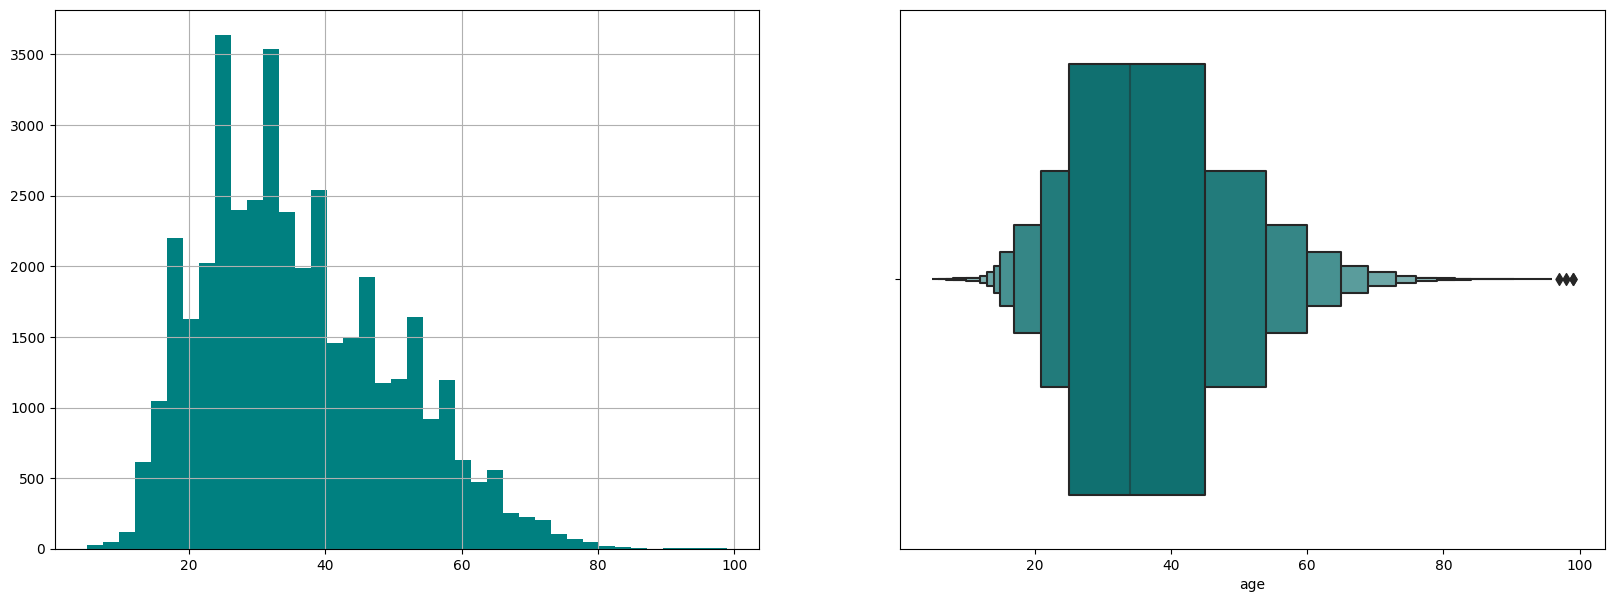

In [21]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [22]:
users['age'].value_counts()

age
29.0    1290
26.0    1250
25.0    1243
34.0    1215
27.0    1207
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: count, Length: 91, dtype: int64

In [23]:
users['age'].nunique()

91

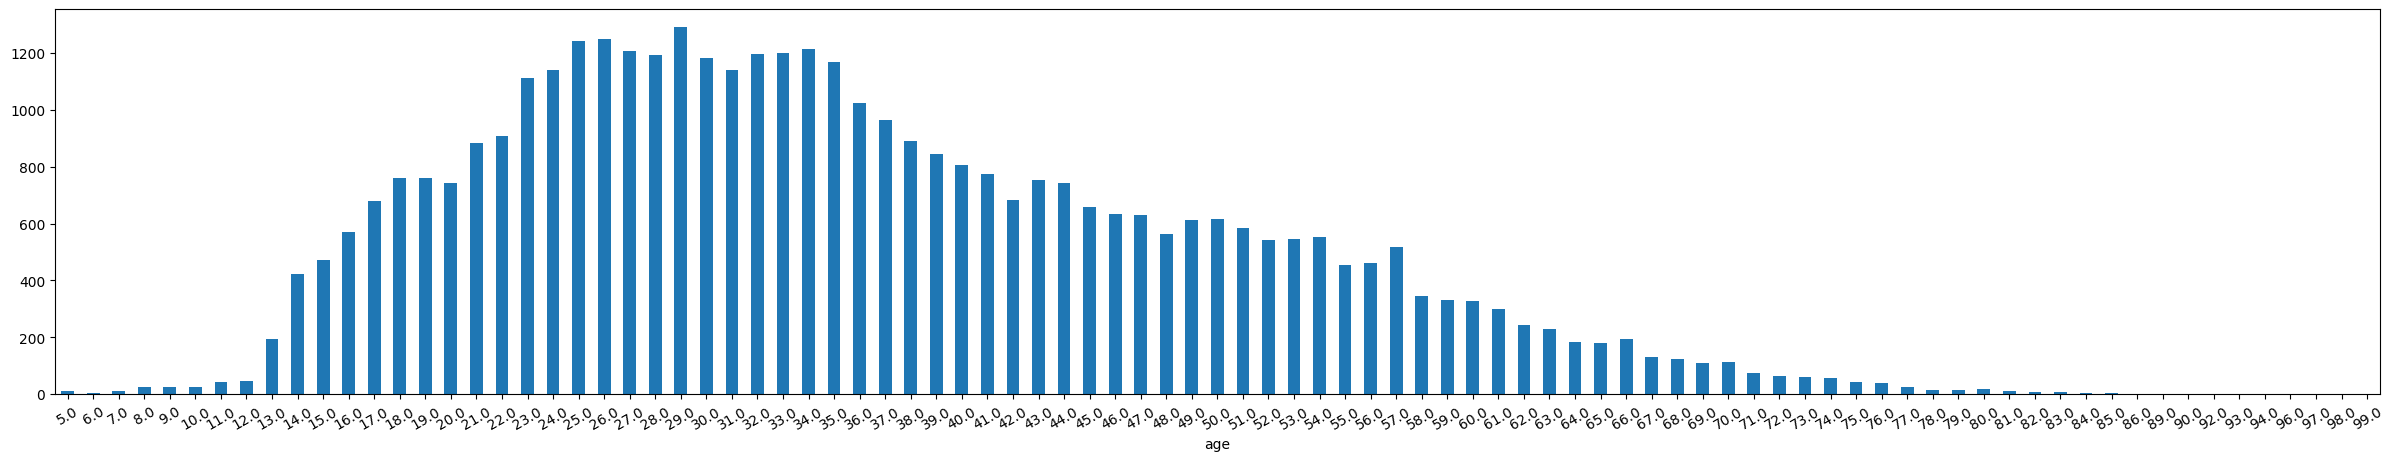

In [24]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

20대 중반 ~ 30대 중반까지의 사용자가 많은 것을 확인할 수 있습니다.

이번에는 사용자들의 거주 국가를 살펴보고 국가별로 사용자의 분포가 다른지 알아보겠습니다.

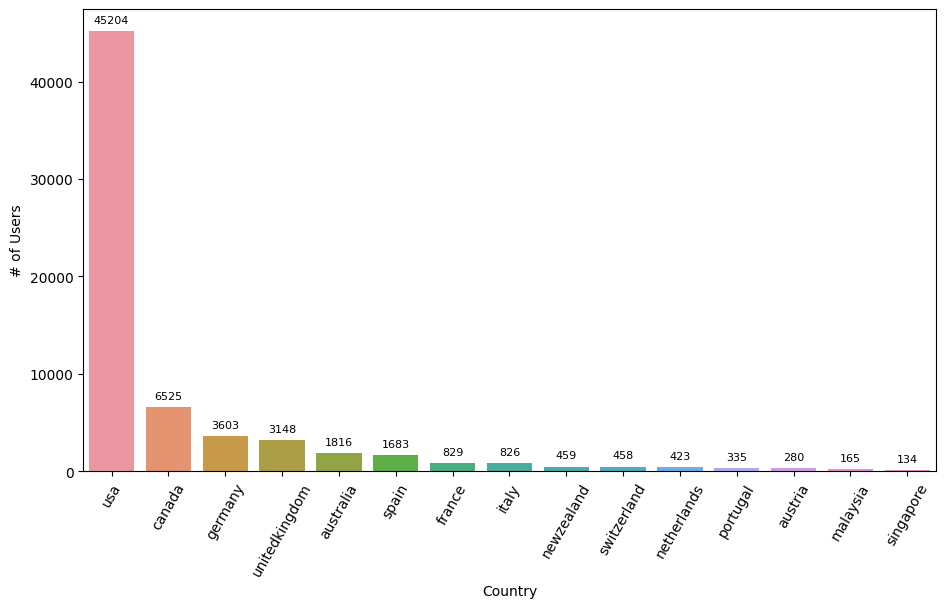

In [25]:
my_dict=(users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

사용자의 대다수는 미국에 거주중인 것을 확인할 수 있습니다.

국가별 사용자의 나이대를 알아보겠습니다.



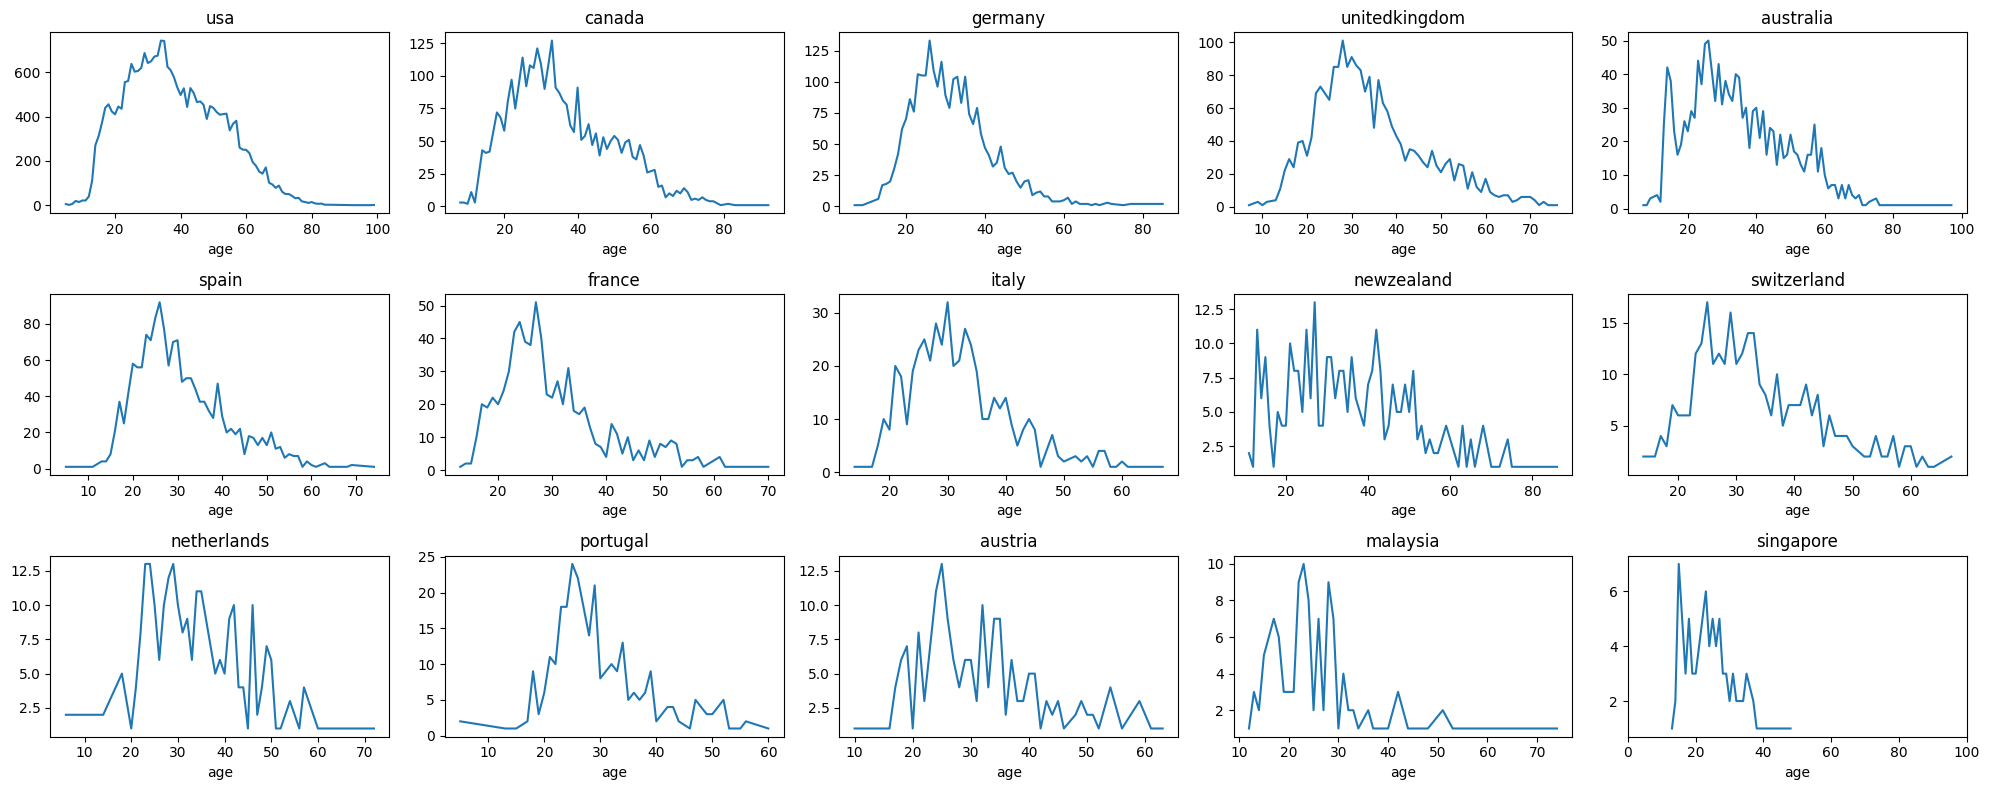

In [26]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

대부분 20~30대 사용자가 많지만, 국가별로 사용자의 분포가 약간씩 차이가 있는 것을 확인할 수 있습니다.

age의 결측값을 살펴보겠습니다.

In [27]:
users[users['age'].isna()]['location_country'].value_counts()

location_country
usa                  20214
canada                3139
germany               1105
unitedkingdom          958
australia              477
                     ...  
unitedstaes              1
missouri                 1
unknown                  1
dominicanrepublic        1
macedonia                1
Name: count, Length: 177, dtype: int64

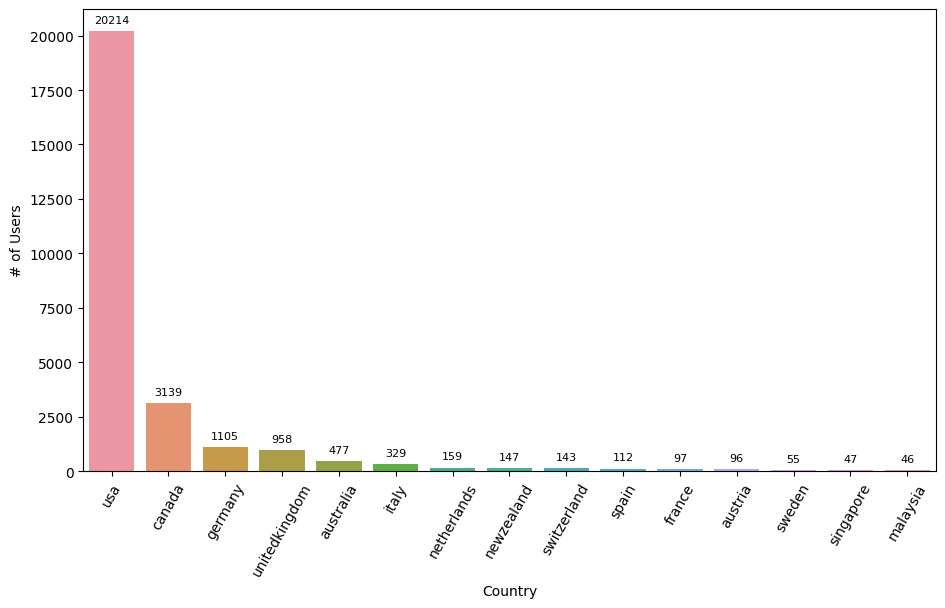

In [28]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

위의 그래프와 큰 차이가 없는 점을 고려했을때, 특정국가에 몰려있다기 보단 골고루 결측치가 퍼져 있다고 판단할 수 있습니다.

국가별 평균, 중앙값, 최빈값 등을 넣어볼수도 있고, 국가별로 큰 나이분포에 큰 차이가 없다고 판단한 경우 전체의 통계치로 채울 수도 있습니다.

또는 결측값을 평균, 중앙값, 최빈값 등의 값으로 채우지 않고 결측값 자체로 가져가는 방법도 있습니다. 

다양한 방법을 시도해보시기 바랍니다.

In [29]:
users = users.drop(columns='location')

## age 결측치 처리
**나라별 최빈 나이**로 대체

In [11]:
age_by_country = users.groupby('location_country')['age'].agg(**{'mode': lambda age: age.mode()}).reset_index()
age_by_country

location_country                mode
0      aberdeenshire                50.0
1        afghanistan        [65.0, 80.0]
2            alabama                  []
3            alachua                60.0
4            albania                  []
..               ...                 ...
263        wisconsin                12.0
264        worcester                  []
265       yugoslavia  [20.0, 21.0, 25.0]
266           zambia                55.0
267         zimbabwe                62.0

[268 rows x 2 columns]

- 최빈값의 빈도가 같은 경우 리스트로 저장됨. => 최빈값 여러 개의 평균을 최종 최빈값으로 선정
- country의 age가 모두 결측치인 경우 빈 리스트를 가짐

In [12]:
for i, m in enumerate(age_by_country['mode']):
    if type(m) != np.float64:
        age_by_country.loc[i, 'mode'] = m.mean()

/tmp/ipykernel_3713/691083138.py:3: RuntimeWarning: Mean of empty slice.
  age_by_country.loc[i, 'mode'] = m.mean()
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
age_by_country

location_country  mode
0      aberdeenshire  50.0
1        afghanistan  72.5
2            alabama   NaN
3            alachua  60.0
4            albania   NaN
..               ...   ...
263        wisconsin  12.0
264        worcester   NaN
265       yugoslavia  22.0
266           zambia  55.0
267         zimbabwe  62.0

[268 rows x 2 columns]

빈 리스트의 평균은 NaN으로 처리됨..
이 결측치들을 특정 값(전체 age 평균)으로 대체했을 때, 해당 나이만 빈도가 너무 커지게 됨.

따라서 나라별 최빈 나이 값들 top 10 중 랜덤으로 뽑아서 대체

In [14]:
age_by_country['mode'].value_counts()

mode
28.000000    10
34.000000     8
27.000000     8
33.000000     7
23.000000     7
             ..
60.500000     1
35.500000     1
25.333333     1
59.000000     1
12.000000     1
Name: count, Length: 91, dtype: int64

In [15]:
import random
random.seed(130)

age_na_df = age_by_country.loc[age_by_country['mode'].isna()]
age_top10 = random.choices(list(users['age'].value_counts().index[:10]), k=age_na_df.shape[0])
age_by_country.loc[age_na_df.index, 'mode'] = age_top10

age_by_country['mode'] = age_by_country['mode'].astype('int') # age 값 정수형으로 변경
age_by_country

location_country  mode
0      aberdeenshire    50
1        afghanistan    72
2            alabama    33
3            alachua    60
4            albania    25
..               ...   ...
263        wisconsin    12
264        worcester    26
265       yugoslavia    22
266           zambia    55
267         zimbabwe    62

[268 rows x 2 columns]

따라서 age가 결측인 user 중 country 값이 있으면 위 df에 따라 결측치 대체

In [16]:
modify_df = users[users['age'].isna() & users['location_country'].notna()]
modify_df

user_id                      location  age location_city   
0            8        timmins,ontario,canada  NaN       timmins  \
6       116866                      ottawa,,  NaN        ottawa   
7       123629       kingston,ontario,canada  NaN      kingston   
9       200273         comber,ontario,canada  NaN        comber   
10      210926         guelph,ontario,canada  NaN        guelph   
...        ...                           ...  ...           ...   
68074   277479     mauldin,southcarolina,usa  NaN       mauldin   
68075   277514              munic,na,germany  NaN         munic   
68084   278248            na,manitoba,canada  NaN           NaN   
68085   278260  burlington,massachusetts,usa  NaN    burlington   
68089   278636         irvington,alabama,usa  NaN     irvington   

      location_state location_country  
0            ontario           canada  
6            ontario           canada  
7            ontario           canada  
9            ontario           canada  
10           ontario           canada  
...              ...              ...  
68074  southcarolina              usa  
68075            NaN          germany  
68084       manitoba           canada  
68085        ontario           canada  
68089        alabama              usa  

[27686 rows x 6 columns]

In [17]:
for a in range(age_by_country.shape[0]):
    users.loc[modify_df[modify_df['location_country'] == age_by_country.loc[a, 'location_country']].index, # users와 modify_df의 인덱스는 일치하는 상태
              'age'] = age_by_country.loc[a, 'mode']

In [18]:
users.isna().sum()

user_id                0
location               0
age                  147
location_city        122
location_state      1132
location_country     271
dtype: int64

age 결측치 개수가 27833개에서 147개로 줄어듦

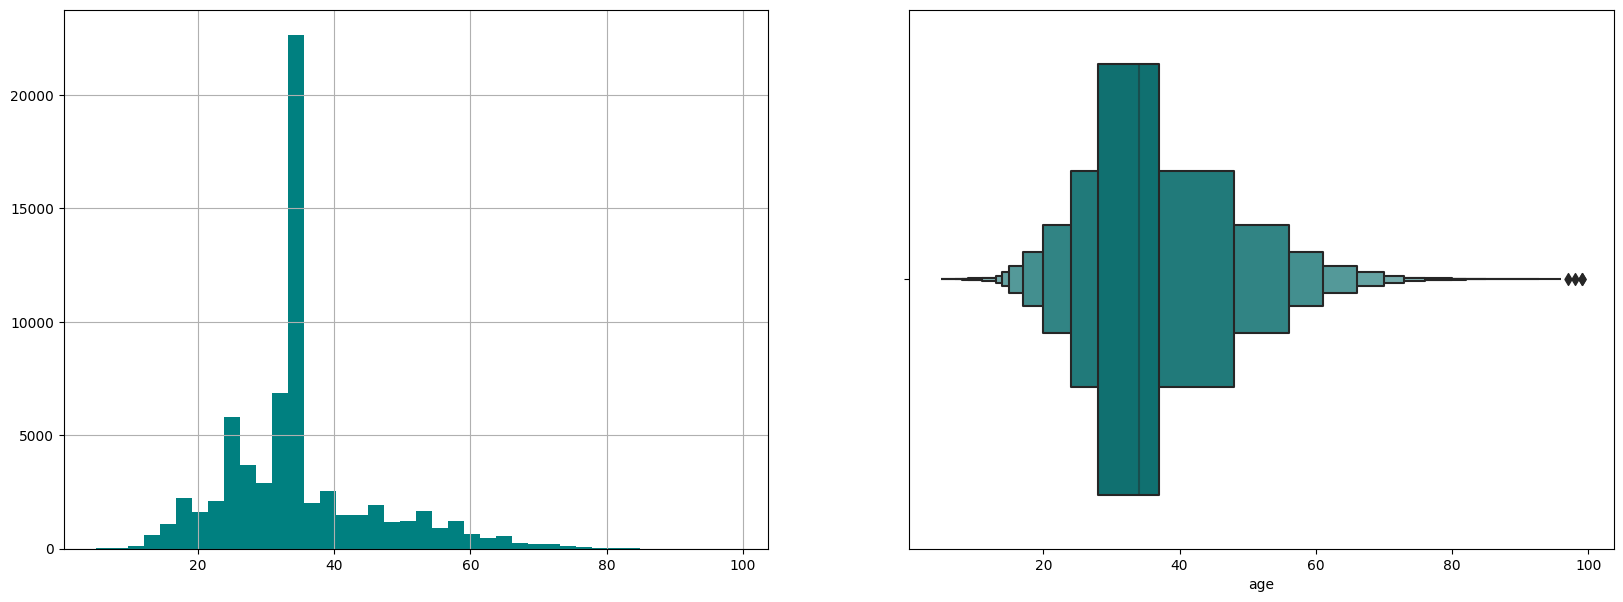

In [19]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [20]:
# users_v1.csv 저장
users.to_csv(path + 'users_v1.csv', index=False)

# books

## book 데이터 확인 [선택 실행]

In [17]:
books.shape

(149570, 10)

In [18]:
books['isbn'].nunique()

149570

In [19]:
books['book_title'].nunique()

135436

In [20]:
books.head()

isbn                                         book_title   
0  0002005018                                       Clara Callan  \
1  0060973129                               Decision in Normandy   
2  0374157065  Flu: The Story of the Great Influenza Pandemic...   
3  0399135782                             The Kitchen God's Wife   
4  0425176428  What If?: The World's Foremost Military Histor...   

            book_author  year_of_publication                 publisher   
0  Richard Bruce Wright               2001.0     HarperFlamingo Canada  \
1          Carlo D'Este               1991.0           HarperPerennial   
2      Gina Bari Kolata               1999.0      Farrar Straus Giroux   
3               Amy Tan               1991.0          Putnam Pub Group   
4         Robert Cowley               2000.0  Berkley Publishing Group   

                                             img_url language       category   
0  http://images.amazon.com/images/P/0002005018.0...       en  ['Actresses']  \
1  http://images.amazon.com/images/P/0060973129.0...       en  ['1940-1949']   
2  http://images.amazon.com/images/P/0374157065.0...       en    ['Medical']   
3  http://images.amazon.com/images/P/0399135782.0...       en    ['Fiction']   
4  http://images.amazon.com/images/P/0425176428.0...       en    ['History']   

                                             summary   
0  In a small town in Canada, Clara Callan reluct...  \
1  Here, for the first time in paperback, is an o...   
2  Describes the great flu epidemic of 1918, an o...   
3  A Chinese immigrant who is convinced she is dy...   
4  Essays by respected military historians, inclu...   

                            img_path  
0  images/0002005018.01.THUMBZZZ.jpg  
1  images/0060973129.01.THUMBZZZ.jpg  
2  images/0374157065.01.THUMBZZZ.jpg  
3  images/0399135782.01.THUMBZZZ.jpg  
4  images/0425176428.01.THUMBZZZ.jpg

In [21]:
books.isna().sum() #language, category, summary에 결측값이 있습니다

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [22]:
books[books['language'].isna() & books['summary'].notnull()]

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, img_url, language, category, summary, img_path]
Index: []

In [23]:
books[books['language'].notnull() & books['summary'].isna()]

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, img_url, language, category, summary, img_path]
Index: []

In [24]:
books[books['language'].isna() & books['category'].notnull()]

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, img_url, language, category, summary, img_path]
Index: []

In [25]:
books[books['language'].notnull() & books['category'].isna()] 

isbn                                         book_title   
138     2070567842        Folio Junior: L'histoire De Monsieur Sommer  \
193     3596292646                Das Buch der lÃ?Â¤cherlichen Liebe.   
486     0871131811                           Zodiac: The Eco-Thriller   
880     067144378X                                         SABLE MOON   
1001    0345339711     The Two Towers (The Lord of the Rings, Part 2)   
...            ...                                                ...   
149252  3770401697  Lucky Luke, Bd.58, Die Geister-Ranch und ander...   
149307  0806917695  Perplexing Lateral Thinking Puzzles: Scholasti...   
149329  3426192543    Im FrÃ?Â¼hling singt zum letztenmal die Lerche.   
149441  2253054615                                        Le maharani   
149529  0812531558                                         Tweedlioop   

                  book_author  year_of_publication                 publisher   
138            Su>skind-Sempe               1994.0        Gallimard-Jeunesse  \
193             Milan Kundera               2000.0  Fischer (Tb.), Frankfurt   
486           Neal Stephenson               1988.0            Pub Group West   
880            Nancy Springer               1981.0                    Pocket   
1001           J.R.R. TOLKIEN               1986.0                   Del Rey   
...                       ...                  ...                       ...   
149252         Michel Janvier               1989.0      Egmont Ehapa, Berlin   
149307            Paul Sloane               1997.0       Sterling Publishing   
149329  Johannes Mario Simmel               1990.0             Droemer Knaur   
149441             Gita Mehta               1990.0                       LGF   
149529        Stanley Schmidt               1988.0        St. Martin's Press   

                                                  img_url language category   
138     http://images.amazon.com/images/P/2070567842.0...       fr      NaN  \
193     http://images.amazon.com/images/P/3596292646.0...       de      NaN   
486     http://images.amazon.com/images/P/0871131811.0...       en      NaN   
880     http://images.amazon.com/images/P/067144378X.0...       en      NaN   
1001    http://images.amazon.com/images/P/0345339711.0...       en      NaN   
...                                                   ...      ...      ...   
149252  http://images.amazon.com/images/P/3770401697.0...       de      NaN   
149307  http://images.amazon.com/images/P/0806917695.0...       en      NaN   
149329  http://images.amazon.com/images/P/3426192543.0...       de      NaN   
149441  http://images.amazon.com/images/P/2253054615.0...       fr      NaN   
149529  http://images.amazon.com/images/P/0812531558.0...       en      NaN   

                                                  summary   
138     Un petit garçon se pose énormément de question...  \
193     Die im &#39;Buch der lächerlichen Liebe&#39; v...   
486     Sangamon Taylor, an environmental extremist, s...   
880     Seventeen-year-old Prince Trevyn must save the...   
1001    Thus continues the magnificent, bestselling ta...   
...                                                   ...   
149252  Enth. noch: Die Hellseherin, Die Statue und Di...   
149307  Normal situations veer off into the bizarre, c...   
149329  Eine Gruppe von Idealisten nimmt den Kampf geg...   
149441  Elevée à la cour comme toutes les maharani l&#...   
149529  But the government wanted Tweedlioop the alien...   

                                 img_path  
138     images/2070567842.01.THUMBZZZ.jpg  
193     images/3596292646.01.THUMBZZZ.jpg  
486     images/0871131811.01.THUMBZZZ.jpg  
880     images/067144378X.01.THUMBZZZ.jpg  
1001    images/0345339711.01.THUMBZZZ.jpg  
...                                   ...  
149252  images/3770401697.01.THUMBZZZ.jpg  
149307  images/0806917695.01.THUMBZZZ.jpg  
149329  images/3426192543.01.THUMBZZZ.jpg  
149441  images/2253054615.01.THUMBZZZ.jpg  
149529  im

language는 있지만 category가 결측인 경우는 존재합니다.

language가 결측값인 경우, summary도 결측값인 것을 확인할 수 있습니다.

## isbn

먼저 isbn과 img_url, img_path의 연관성을 찾을 수 있습니다.

`isbn`과 img_path, img_url 모두 동일한지 살펴보는 작업을 거치고 isbn의 성질을 이용하여 전처리를 진행해보겠습니다.

In [21]:
books[books['isbn'] != books['img_url'].apply(lambda x: x.split('P/')[1][:10])]

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, img_url, language, category, summary, img_path]
Index: []

In [22]:
books[books['isbn']!=books['img_path'].apply(lambda x: x.split('/')[1][:10])]

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, img_url, language, category, summary, img_path]
Index: []

모두 동일하여 추가적인 작업이 필요없음을 확인했습니다.


isbn은 책의 개별적인 고유번호를 나타내는 10자리 숫자입니다.

출판 국가, 출판사 번호, 항목 번호, 확인 숫자 순서로 구성되며 확인 숫자의 경우 10을 나타내는 X가 오기도 합니다.

이 번호를 활용하여 출판사의 항목 갯수를 줄여보도록 하겠습니다.

In [23]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

In [24]:
publisher_count_df.head()

publisher  count
0         Harlequin   3005
1  Ballantine Books   2322
2            Pocket   2274
3     Penguin Books   1943
4      Bantam Books   1938

In [25]:
books[books['publisher']=="Penguin Books"]

isbn                                         book_title   
68      0140067477                                    The Tao of Pooh  \
119     0143034359  Thursday Next in the Well Of Lost Plots (Thurs...   
157     0140250964                                        Snow Angels   
196     0140272100                                           Vanished   
298     014028009X                              Bridget Jones's Diary   
...            ...                                                ...   
149154  0140423818      Lord Byron: Selected Poems (Penguin Classics)   
149301  0140290788                Time Out Chicago (Time Out Chicago)   
149345  0140182551        The Old Wives' Tale (20th Century Classics)   
149387  0140390715                   The Pathfinder (Penguin Classic)   
149471  0140134212  House of glass: A novel (Penguin international...   

                  book_author  year_of_publication      publisher   
68              Benjamin Hoff               1983.0  Penguin Books  \
119             Fforde Jasper               2004.0  Penguin Books   
157             Stewart O'Nan               1995.0  Penguin Books   
196       Mary McGarry Morris               1997.0  Penguin Books   
298            Helen Fielding               1999.0  Penguin Books   
...                       ...                  ...            ...   
149154    George Gordon Byron               1996.0  Penguin Books   
149301               Time Out               2000.0  Penguin Books   
149345         Arnold Bennett               1990.0  Penguin Books   
149387  James Fenimore Cooper               1989.0  Penguin Books   
149471  Pramoedya Ananta Toer               1992.0  Penguin Books   

                                                  img_url language   
68      http://images.amazon.com/images/P/0140067477.0...       en  \
119     http://images.amazon.com/images/P/0143034359.0...       en   
157     http://images.amazon.com/images/P/0140250964.0...       en   
196     http://images.amazon.com/images/P/0140272100.0...       en   
298     http://images.amazon.com/images/P/014028009X.0...       en   
...                                                   ...      ...   
149154  http://images.amazon.com/images/P/0140423818.0...       en   
149301  http://images.amazon.com/images/P/0140290788.0...      NaN   
149345  http://images.amazon.com/images/P/0140182551.0...       en   
149387  http://images.amazon.com/images/P/0140390715.0...       en   
149471  http://images.amazon.com/images/P/0140134212.0...      NaN   

           category                                            summary   
68        ['Humor']  An expert in Chinese philosophy explains facet...  \
119     ['Fiction']  Exhausted by her stint as Miss Havisham&#39;s ...   
157     ['Fiction']  Weaves together two stories in the account of ...   
196     ['Fiction']  Aubrey Wallace is the kind of man no one notices.   
298     ['Fiction']  This witty national bestseller is now availabl...   
...             ...                                                ...   
149154   ['Poetry']  &quot; &quot;Byron&#39;s contemporary populari...   
149301          NaN                                                NaN   
149345  ['Fiction']  Victorian novel set in the pottery district of...   
149387  ['Fiction']  Cooper undertakes a &quot;hazardous experiment...   
149471          NaN                                                NaN   

                                 img_path  
68      images/0140067477.01.THUMBZZZ.jpg  
119     images/0143034359.01.THUMBZZZ.jpg  
157     images/0140250964.01.THUMBZZZ.jpg  
196     images/0140272100.01.THUMBZZZ.jpg  
298     images/014028009X.01.THUMBZZZ.jpg  
...                                   ...  
149154  images/0140423818.01.THUMBZZZ.jpg  
149301  images/0140290788.01.THUMBZZZ.jpg  
149345  images/0140182551.01.THUMBZZZ.jpg  
149387  images/0140390715.01.THUMBZZZ.jpg  
149471  images/0140134212.01.THUMBZZZ.jpg  

[1943 rows x 10 columns]

유명출판사를 조회하여 보면 isbn의 시작이 모두 0140으로 시작하는 것을 확인할 수있습니다. 

그러나 표기 방법의 차이 및 오타로 인해 같은 그룹으로 묶이지 못하는 항목이 있습니다.

이런 항목을 수정해보겠습니다.

In [26]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [27]:
books[books['isbn'].apply(lambda x: x[:4])=='0140']['publisher'].unique()

array(['Penguin Books', 'Penguin Books Ltd', 'Puffin Books',
       'Penguin USA (Paper)', 'Penguin USA', 'Puffin',
       'Penguin Putnam~trade', 'Penguin Putnam~mass',
       'Penguin/Puffin Mass Market (Mm)', 'Viking Books',
       'Penguin Books Australia Ltd', 'Penguin Uk',
       'Scott Foresman (Pearson K-12)',
       'Penguin Putnam Books for Young Readers',
       'French & European Pubns', 'Viking Penguin', 'Arkana',
       'Penguin Highbridge Audio', 'Penguin (Non-Classics)',
       'Penguin Books, Limited (UK)', 'Viking Press', 'Penguin U S A',
       'Penguin/Puffin Mass Market', 'Select Penguin (Mm)',
       'Penguin Putnam', 'Penguin Books India', 'Select Penguin',
       'Penguin Books Australia Ltd.', 'Viking Penguin Inc',
       'Penguin Audiobooks', 'Studio Books', 'Penguin',
       'Hyperion Books for Children', 'Putnam Pub Group', 'Penguin India',
       'Compass Books', 'Penguin Putnam~childrens Hc',
       'Penguin in association with Secker and Warburg', 'Time O

In [28]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

In [29]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [30]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다

1523

## category

category를 칼럼의 항목을 대괄호 밖으로 빼는 과정을 거친 뒤 어떤 category가 있는지 살펴보겠습니다

In [31]:
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

In [32]:
books['category'].value_counts()

category
Fiction                                            32956
Juvenile Fiction                                    5804
Biography Autobiography                             3320
History                                             1925
Religion                                            1818
                                                   ...  
Eschatology                                            1
Dogsledding                                            1
Brenner Simon Fictitious character                     1
Gone with the wind Motion picture 1939                 1
Authors Canadian English 20th century Biography        1
Name: count, Length: 4137, dtype: int64

In [33]:
books['category'] = books['category'].str.lower()

In [34]:
books['category'].value_counts()

category
fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [35]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
category_df.head()

category  count
0                  fiction  33016
1         juvenile fiction   5835
2  biography autobiography   3326
3                  history   1927
4                 religion   1818

In [36]:
category_df[category_df['count']>=10]

category  count
0                      fiction  33016
1             juvenile fiction   5835
2      biography autobiography   3326
3                      history   1927
4                     religion   1818
..                         ...    ...
253  children s poetry english     10
254            abused children     10
255                    courage     10
256              diary fiction     10
257            spanish fiction     10

[258 rows x 2 columns]

카테고리를 보면 4000개가 넘는 종류를 갖고 있고, 카테고리 항목 개수가 10개 이상인 카테고리는 250개가 좀 넘습니다.

많은 카테고리가 그룹화 안된 채로 존재한다고 볼 수 있습니다.

이러한 카테고리를 좀더 큰 카테고리로 묶어주어 카테고리의 가짓수를 줄일 수 있습니다.

## categorization

In [37]:
from collections import defaultdict

categories = defaultdict(int)

for category in category_df['category']:
    cs = category.split()
    for c in cs:
        categories[c] += 1

common_category = []
for k, v in categories.items():
    if v >= 10 and len(k) > 3:
        common_category.append(k)

common_category.append('law')
common_category.append('art')
common_category.append('man')
common_category.append('gay')
common_category.append('men')
common_category.append('war')
common_category.append('god')
common_category.append('dog')
common_category.append('cat')
common_category.append('sex')

print(common_category)

# law art man gay men war god dog cat sex

['fiction', 'social', 'science', 'humor', 'body', 'business', 'cooking', 'family', 'self', 'psychology', 'poetry', 'philosophy', 'drama', 'arts', 'language', 'education', 'music', 'detective', 'mystery', 'stories', 'children', 'photography', 'animals', 'adventure', 'american', 'english', 'christian', 'life', 'england', 'fantasy', 'german', 'authors', 'african', 'americans', 'france', 'french', 'literature', 'books', 'motion', 'picture', 'child', 'indians', 'germany', 'cookery', 'australian', 'short', 'behavior', 'canadian', 'medicine', '1945', 'imaginary', 'place', 'computer', 'fictitious', 'character', 'women', 'electronic', 'calif', 'spanish', 'communication', 'characters', 'school', 'human', 'program', 'animal', 'mythology', 'ethics', 'culture', 'management', 'greek', 'book', 'portuguese', 'game', 'films', 'texts', 'chinese', 'trade', 'geschichte', 'belletristische', 'darstellung', 'television', 'industry', 'black', 'programs', 'law', 'art', 'man', 'gay', 'men', 'war', 'god', 'dog',

In [38]:
for category in common_category:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df

category  count
0      fiction  40551
1      science   2381
2          art   1581
3        humor   1166
4         body   1123
..         ...    ...
76   imaginary      8
77         gay      7
78  geschichte      5
79     mystery      3
80   detective      1

[81 rows x 2 columns]

In [39]:
books.loc[books[books['category'].notna() & books['category_high'].isna()].index, 'category_high']='others'

In [40]:
books['category'].nunique()

4105

In [41]:
books['category_high'].nunique()

82

In [42]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

## language 결측치 처리

In [43]:
pub = books['publisher'].unique()

for p in pub:
    if not (books[(books['publisher'] == p) & (books['language'].notna())]['language'].value_counts().empty):
        books.loc[(books['publisher'] == p) & (books['language'].isna()), 'language'] = books[(books['publisher'] == p) & (books['language'].notna())]['language'].value_counts().index[0]

books[(books['publisher'].notna()) & (books['language'].isna())]['publisher'].value_counts()

publisher
GlÃ?Â©nat                         36
Unionsverlag                      27
Bruguera                          15
Egmont Franz Schneider Verlag     14
Hachette                          13
                                  ..
Walter De Gruyter Inc              1
Nicolai                            1
Knjizevna zajednica Novog Sada     1
Panamericana Pub Llc               1
Information                        1
Name: count, Length: 604, dtype: int64

In [44]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language                1130
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

In [45]:
books.to_csv(path + 'books_v1.csv', index=False)

## 시각화 [선택 실행]
- 이미지 url 활용

이번에는 이미지를 살펴보겠습니다.
먼저 url를 이용해서 이미지를 불러오는 방법을 알아보겠습니다.

In [136]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

In [137]:
books[books['book_title'].str.contains('Harry')]

isbn                                         book_title   
390     0439064864   Harry Potter and the Chamber of Secrets (Book 2)  \
391     0439064872   Harry Potter and the Chamber of Secrets (Book 2)   
392     0439136350  Harry Potter and the Prisoner of Azkaban (Book 3)   
393     0439136369  Harry Potter and the Prisoner of Azkaban (Book 3)   
394     0439139597       Harry Potter and the Goblet of Fire (Book 4)   
...            ...                                                ...   
140403  0743202430  Eleanor and Harry : The Correspondence of Elea...   
142947  0972322108  The Hidden Key to Harry Potter: Understanding ...   
143065  0743223748  Harry and Ike: The Partnership That Remade the...   
145141  3895849618  Harry Potter und der Gefangene von Askaban. So...   
147880  0819308854                      Horseshoe Harry and the Whale   

              book_author  year_of_publication                  publisher   
390         J. K. Rowling               1999.0                 Scholastic  \
391         J. K. Rowling               2000.0                 Scholastic   
392         J. K. Rowling               1999.0                 Scholastic   
393         J. K. Rowling               2001.0                 Scholastic   
394         J. K. Rowling               2000.0                 Scholastic   
...                   ...                  ...                        ...   
140403  Eleanor Roosevelt               2002.0                     Pocket   
142947       John Granger               2002.0  Global Authors Publishers   
143065         Steve Neal               2002.0                     Pocket   
145141  Joanne K. Rowling               2002.0                   Konemann   
147880     Adele De Leeuw               1976.0     Parents Magazine Press   

                                                  img_url language   
390     http://images.amazon.com/images/P/0439064864.0...       en  \
391     http://images.amazon.com/images/P/0439064872.0...      NaN   
392     http://images.amazon.com/images/P/0439136350.0...       en   
393     http://images.amazon.com/images/P/0439136369.0...      NaN   
394     http://images.amazon.com/images/P/0439139597.0...       en   
...                                                   ...      ...   
140403  http://images.amazon.com/images/P/0743202430.0...      NaN   
142947  http://images.amazon.com/images/P/0972322108.0...       en   
143065  http://images.amazon.com/images/P/0743223748.0...       en   
145141  http://images.amazon.com/images/P/3895849618.0...      NaN   
147880  http://images.amazon.com/images/P/0819308854.0...      NaN   

                       category   
390            juvenile fiction  \
391                         NaN   
392            juvenile fiction   
393                         NaN   
394            juvenile fiction   
...                         ...   
140403                      NaN   
142947                 children   
143065  biography autobiography   
145141                      NaN   
147880                      NaN   

                                                  summary   
390     In Harry Potter and the Chamber of Secrets, th...  \
391                                                   NaN   
392     During his third year at Hogwarts School for w...   
393                                                   NaN   
394     The fourth title in the continuing saga includ...   
...                                                   ...   
140403                                                NaN   
142947  The Hidden Key to Harry Potter is the first bo...   
143065  In the first biography to examine in depth the...   
145141                                                NaN   
147880                                                NaN   

                                 img_path            category_high  
390     images/0439064864.01.THUMBZZZ.jpg                  fiction  
391     images/0439064872.01.THUMBZZZ.jpg                      NaN  
392     im

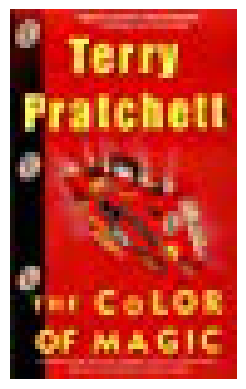

In [138]:
fig= plt.plot(figsize=(3,4))
url = books['img_url'][286]
img = np.asarray(Image.open(requests.get(url, stream=True, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
plt.axis("off")
plt.imshow(img)

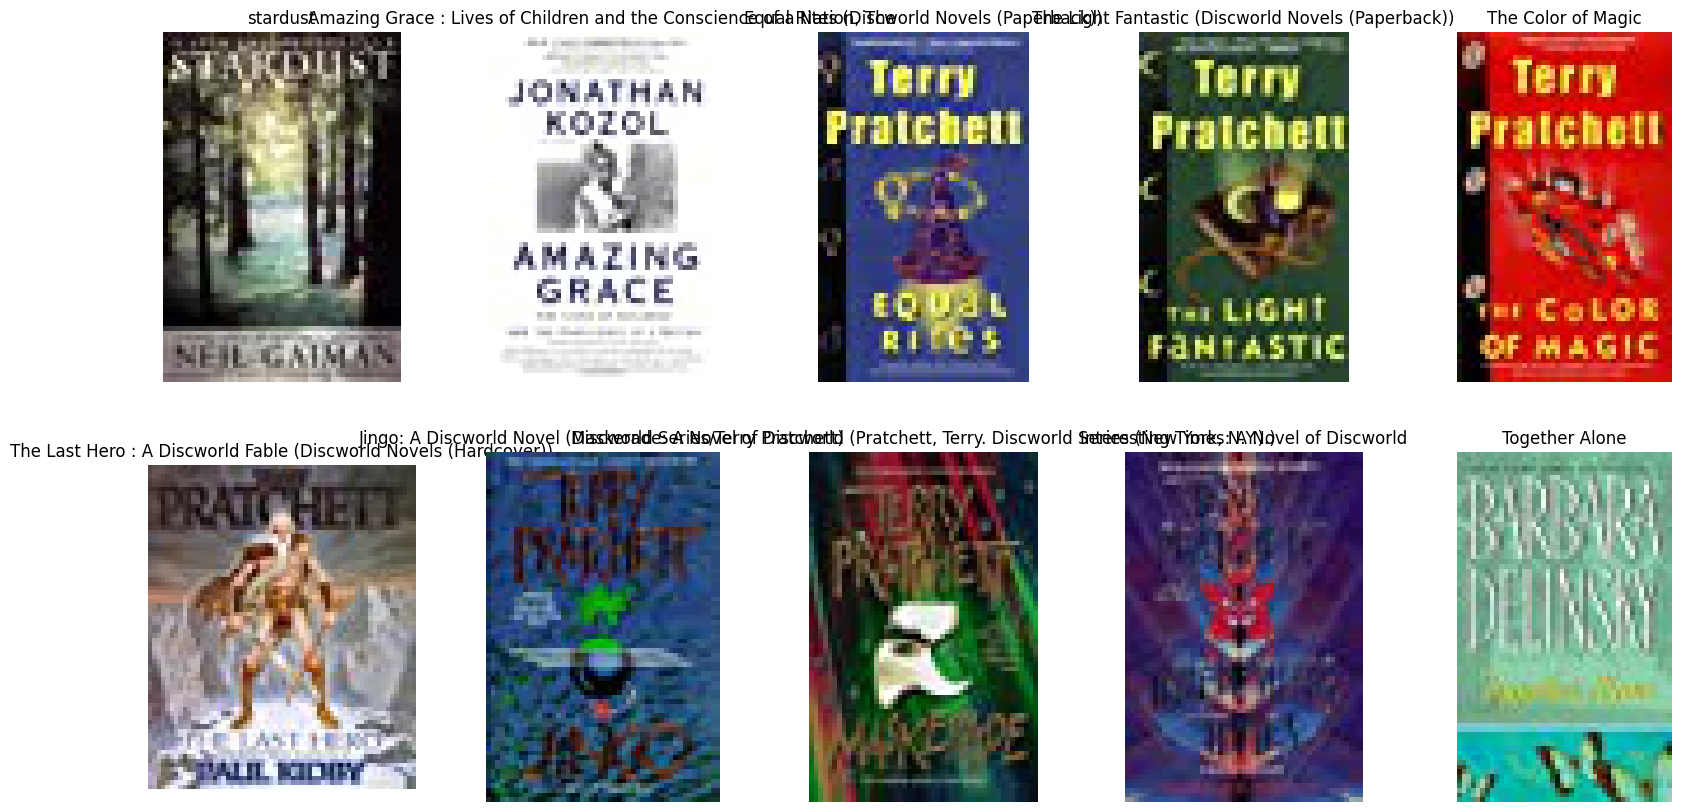

In [139]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10)) 
for i, ax in zip(range(282, 292), ax.flatten()):
    url = books['img_url'][i]
    img = np.asarray(Image.open(requests.get(url, stream=True, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

- img path 활용

img 파일을 활용해서 불러오는 방법을 알아보겠습니다.

zip 파일을 열고, 관련있는 데이터만 가져와서 사용하겠습니다.

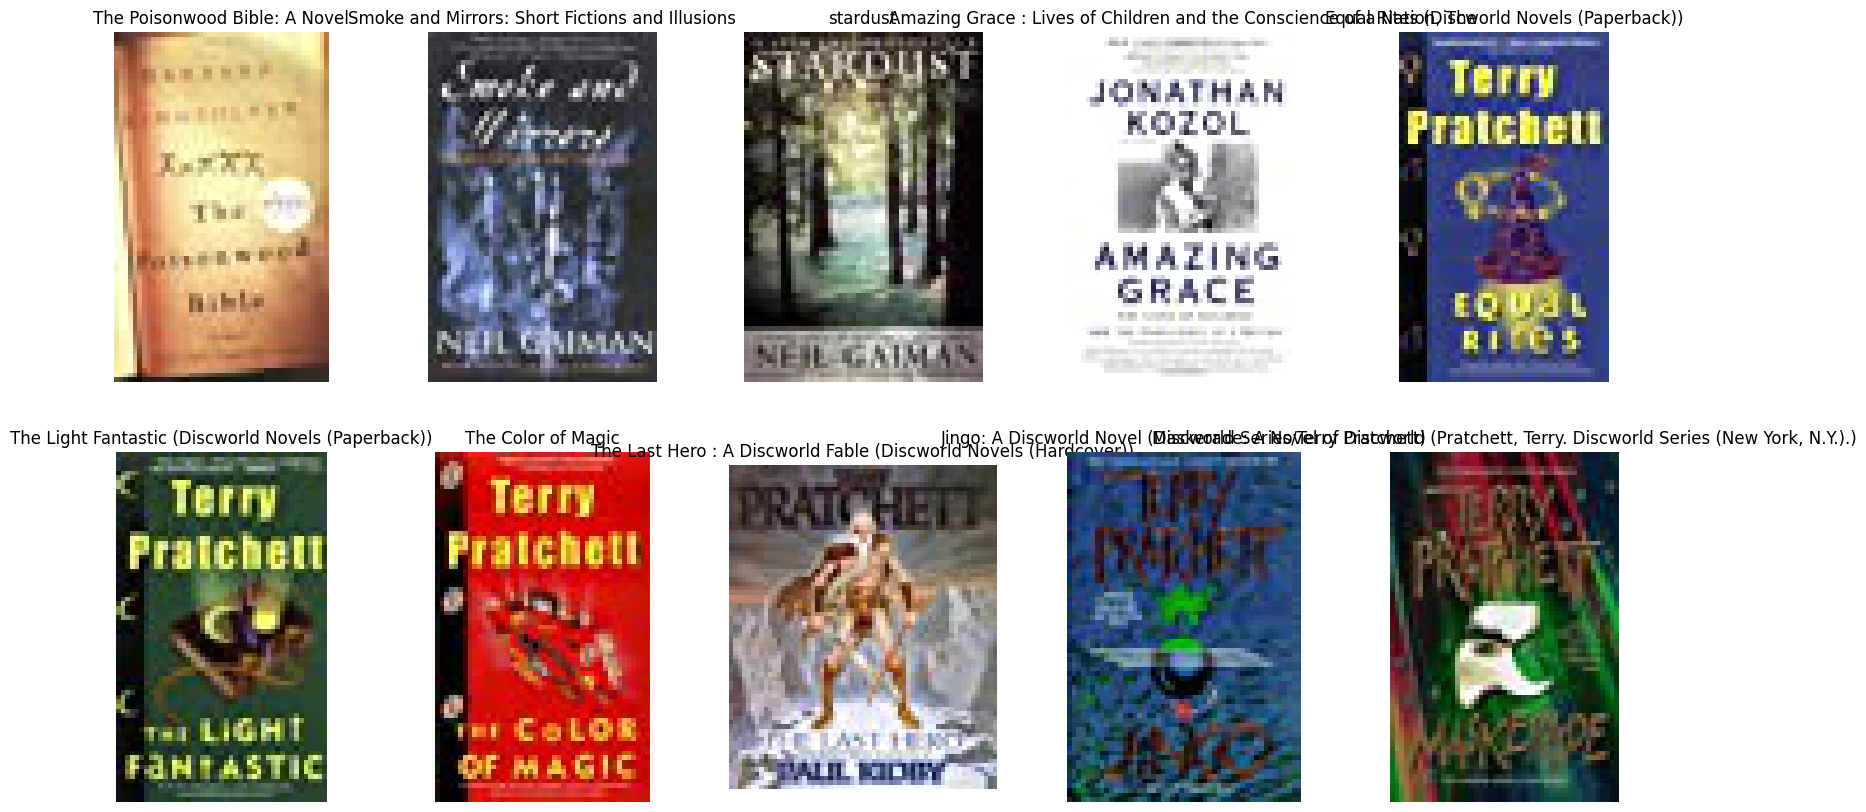

In [144]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10)) 

for i, ax in zip(range(280, 290), ax.flatten()):
    file_path = path+books['img_path'][i]
    img = np.asarray(Image.open(file_path))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

- 그 외 시각화


In [145]:
books['publisher'].value_counts().head(10)

publisher
Pocket                7306
Harlequin             5268
Bantam Books          4815
St. Martin's Press    4043
Vintage Books USA     3822
Penguin Books         3807
Perennial             3313
Ballantine Books      3090
Signet Book           3068
Avon                  2792
Name: count, dtype: int64

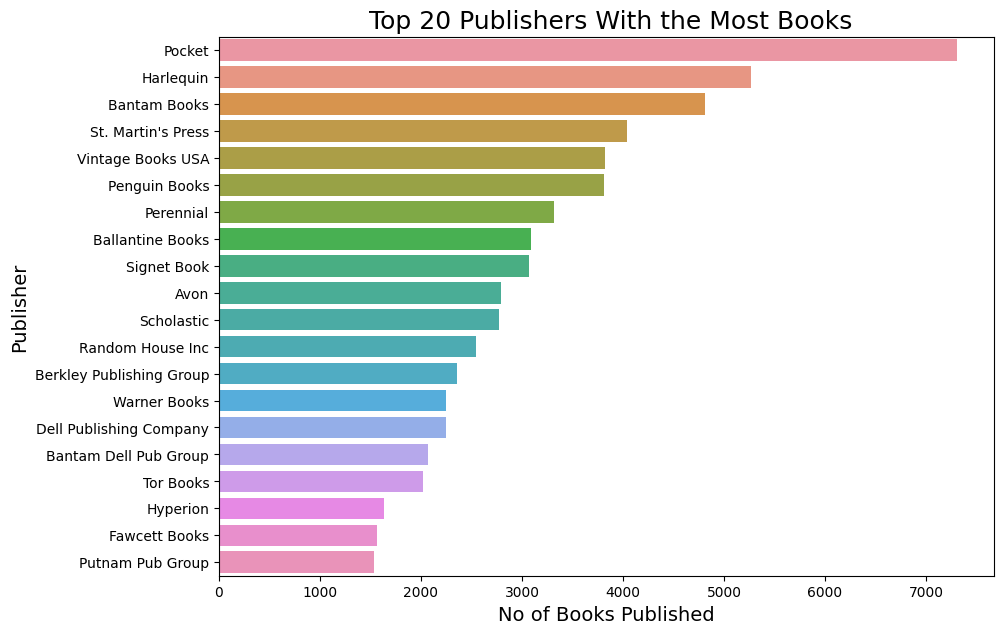

In [146]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

b = publisher_count_df.sort_values(by=['count'], ascending = False)
b = b.head(20)

fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'publisher' , data = b)

plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)

plt.show()

In [147]:
print(sorted(books['year_of_publication'].unique()),end=' ') 

[1376.0, 1378.0, 1806.0, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1911.0, 1920.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0] 

1900~2001년까지 출간된 책이 존재하고 있습니다.

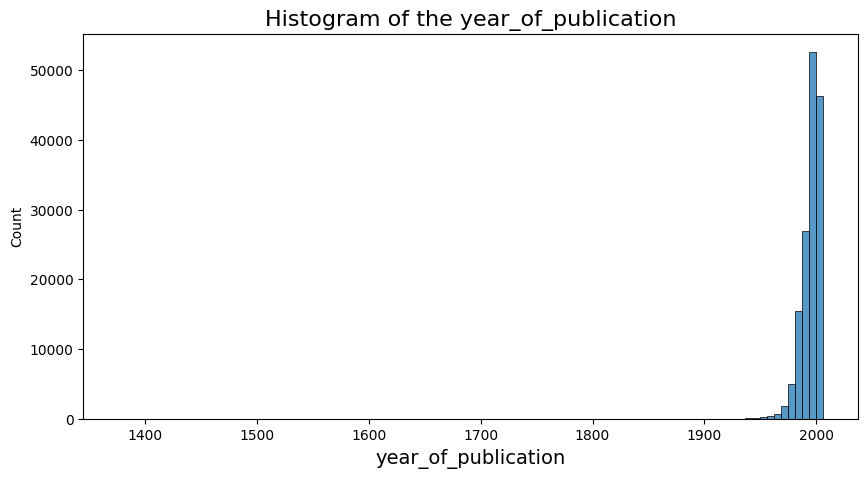

In [148]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

In [149]:
books['year_of_publication'].value_counts().sort_index()

year_of_publication
1376.0        1
1378.0        1
1806.0        1
1900.0        1
1901.0        4
          ...  
2002.0    11669
2003.0     9430
2004.0     3771
2005.0       19
2006.0        1
Name: count, Length: 95, dtype: int64

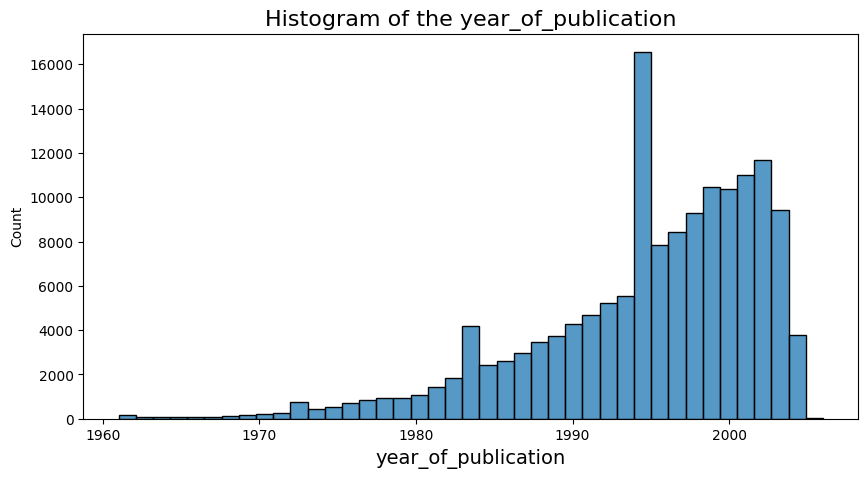

In [150]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']>1960]['year_of_publication'],bins=41)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

In [157]:
books[books['year_of_publication']>1960]['year_of_publication'].value_counts()

year_of_publication
2002.0    11669
2001.0    11020
1999.0    10480
2000.0    10391
2003.0     9430
1998.0     9300
1994.0     9058
1997.0     8439
1996.0     7853
1995.0     7494
1993.0     5554
1992.0     5209
1991.0     4692
1990.0     4279
2004.0     3771
1989.0     3751
1988.0     3473
1987.0     2976
1986.0     2616
1985.0     2433
1984.0     2214
1983.0     1972
1982.0     1848
1981.0     1438
1980.0     1088
1978.0      944
1979.0      931
1977.0      837
1976.0      697
1975.0      541
1974.0      440
1973.0      410
1972.0      366
1971.0      249
1970.0      221
1969.0      178
1968.0      124
1965.0       94
1966.0       92
1967.0       89
1961.0       76
1962.0       73
1964.0       72
1963.0       70
2005.0       19
2006.0        1
Name: count, dtype: int64

1970년 이전의 책은 몇권 없는 것을 확인할 수 있습니다.

데이터의 책들은 1990년 이후의 책이 대다수입니다.

# ratings [여기부터는 작업 필요]

ratings 파일은 사용자가 특정 책을 읽고 점수를 매긴 데이터 입니다.

 `user_id`, `isbn`, `rating` 으로 이뤄져있습니다.

 한 사용자가 다른 책을 여러번 읽기 때문에 중복된 값이 나타나게 되지만,
 
 users에 있는 모든 사용자가 포함된 데이터입니다.

In [46]:
train_ratings.head()

user_id        isbn  rating
0        8  0002005018       4
1    67544  0002005018       7
2   123629  0002005018       8
3   200273  0002005018       8
4   210926  0002005018       9

In [47]:
train_ratings['user_id'].nunique()

59803

In [48]:
train_ratings.shape

(306795, 3)

In [49]:
train_ratings['rating'].value_counts(True)

rating
8     0.239877
7     0.172519
9     0.158650
10    0.139422
6     0.082501
5     0.045995
1     0.043185
2     0.042142
4     0.041419
3     0.034290
Name: proportion, dtype: float64

rating은 1~10값을 가지며 8이 가장 많습니다.

총 306795명의 사용자들이 평가한 정보가 있습니다.

## 시각화

In [ ]:
#유저당 몇 권 정도의 책을 읽었는지 살펴보겠습니다.
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)

user_id
11676     2901
153662     794
16795      562
95359      427
257204     422
          ... 
80077        1
80404        1
176742       1
80704        1
137678       1
Name: rating, Length: 14110, dtype: int64

유저는 1권에서 2901권까지 책을 읽은 것으로 보입니다.
특히 한 유저만 2000권 이상의 많은 책을 읽었습니다.

많은 책을 읽은 유저들의 rating 분포와 그렇지 않은 유저들의 분포를 살펴보겠습니다.

In [ ]:
heavy_users_list = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index

In [ ]:
ratings[ratings['user_id'].isin(heavy_users_list)].groupby('user_id')['rating'].mean()

user_id
11676     7.133747
16795     6.000000
23902     7.563177
35859     6.158209
60244     6.409677
95359     6.618267
98391     8.538012
100906    6.464164
104636    8.194357
107784    3.486577
114368    6.082803
135149    5.996988
153662    6.654912
158295    5.167582
171118    7.024169
185233    3.391447
204864    6.518519
235105    5.029851
248718    6.363636
257204    6.111374
Name: rating, dtype: float64

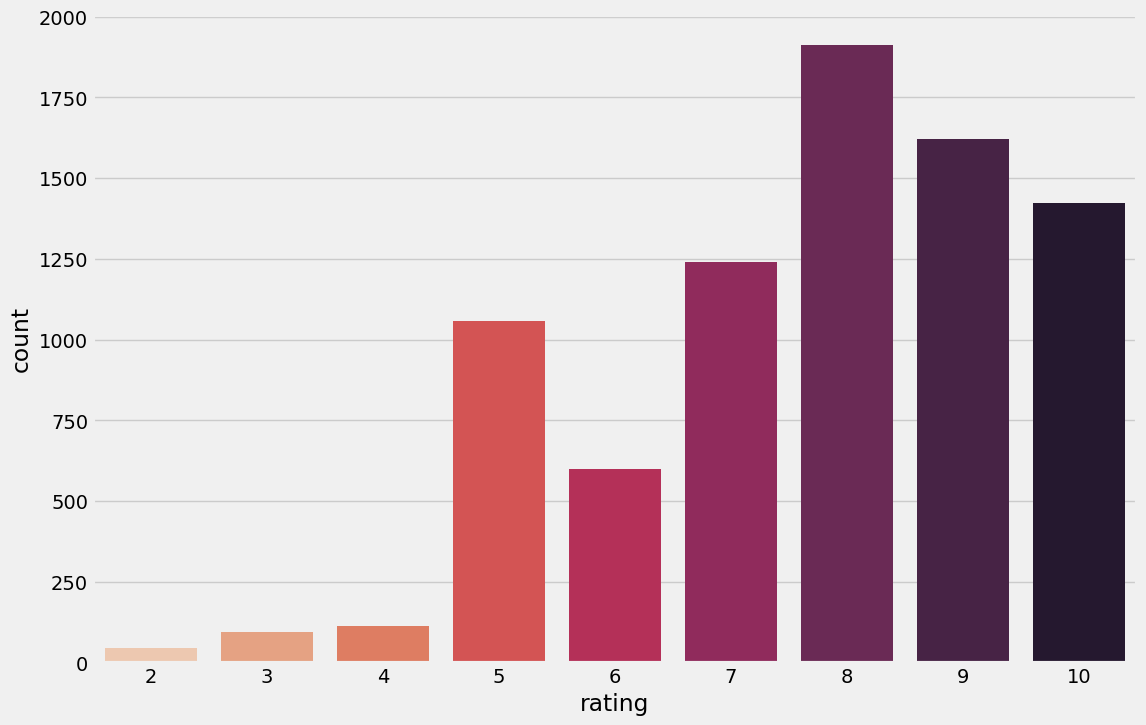

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[(ratings['user_id'].isin(heavy_users_list))&(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

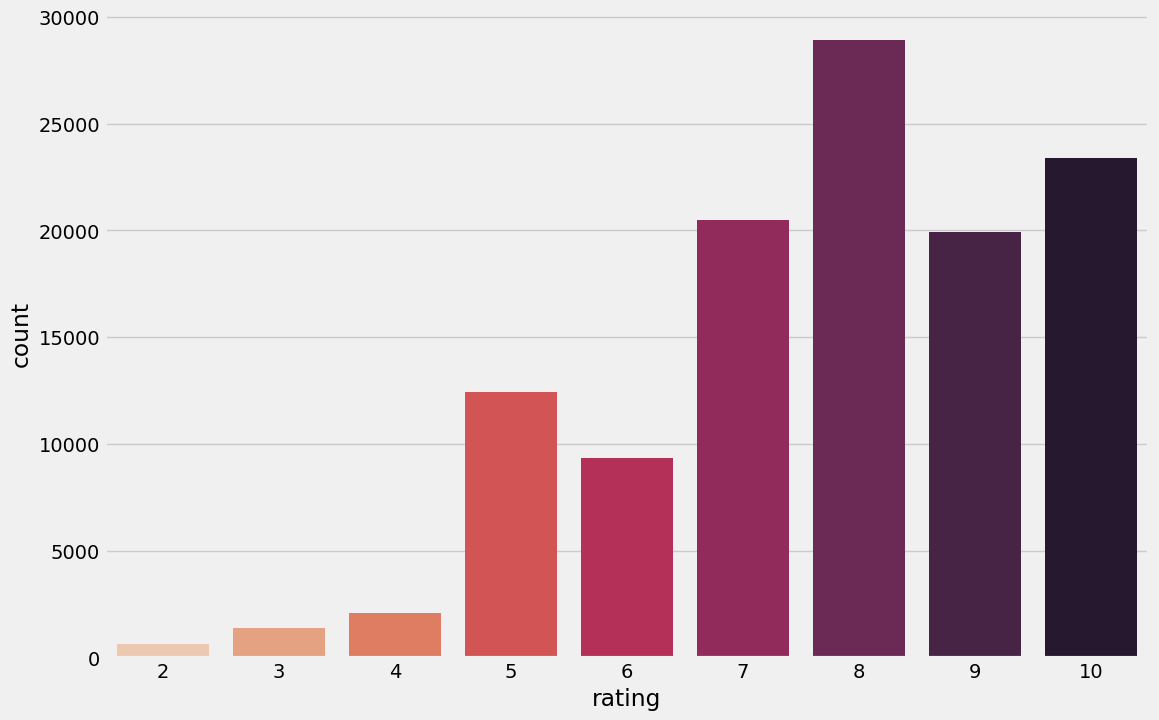

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[~(ratings['user_id'].isin(heavy_users_list))&(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

heavy 유저들이 상대적으로 10점을 잘 안주는 것으로 보여집니다.

이번에는 가장 인기 있는 책은 몇번 읽혔는지 알아보겠습니다.

In [ ]:
ratings.groupby('isbn')['rating'].count().sort_values(ascending=False)

isbn
0312195516    303
0060928336    280
059035342X    269
0671027360    257
0446672211    252
             ... 
0439164524      1
0449221156      1
1558211853      1
0449220850      1
0385495056      1
Name: rating, Length: 20871, dtype: int64

가장 인기있는 책은 303번 읽혔습니다. 

데이터 merge 이후 해당 책이 무엇인지 알아보겠습니다.

현재 점수는 1~10점으로 분류되어 있으며 1점이 가장 많습니다.

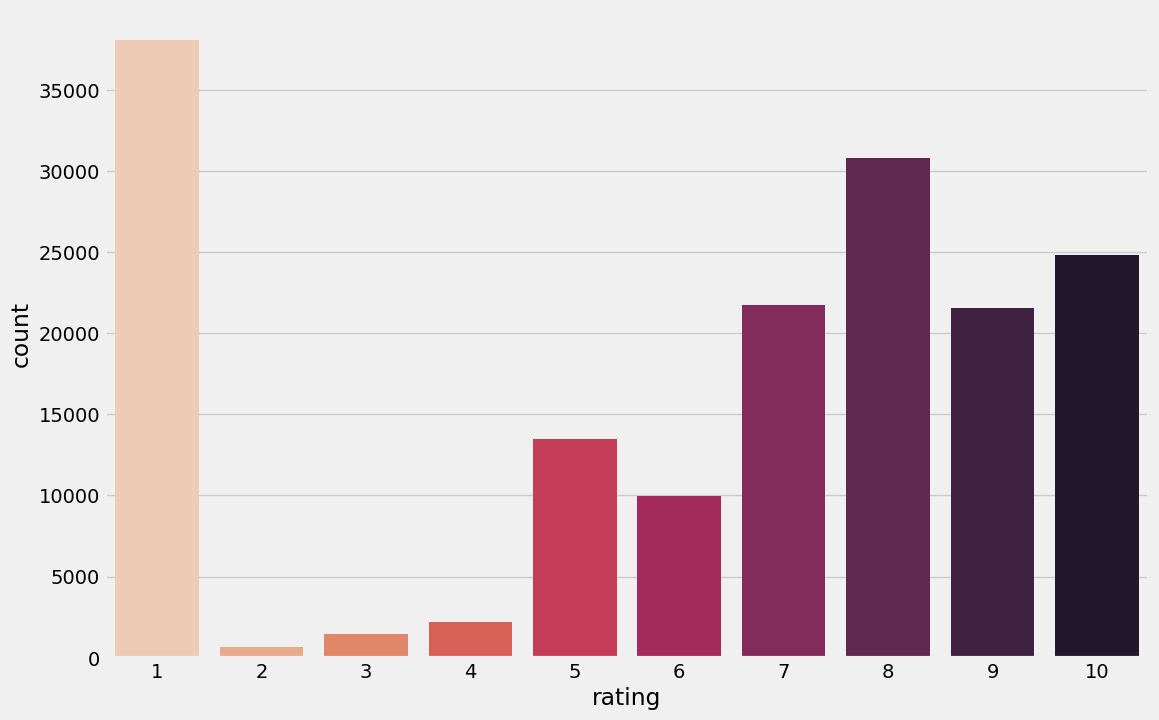

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings , x='rating', palette='rocket_r')
plt.show()


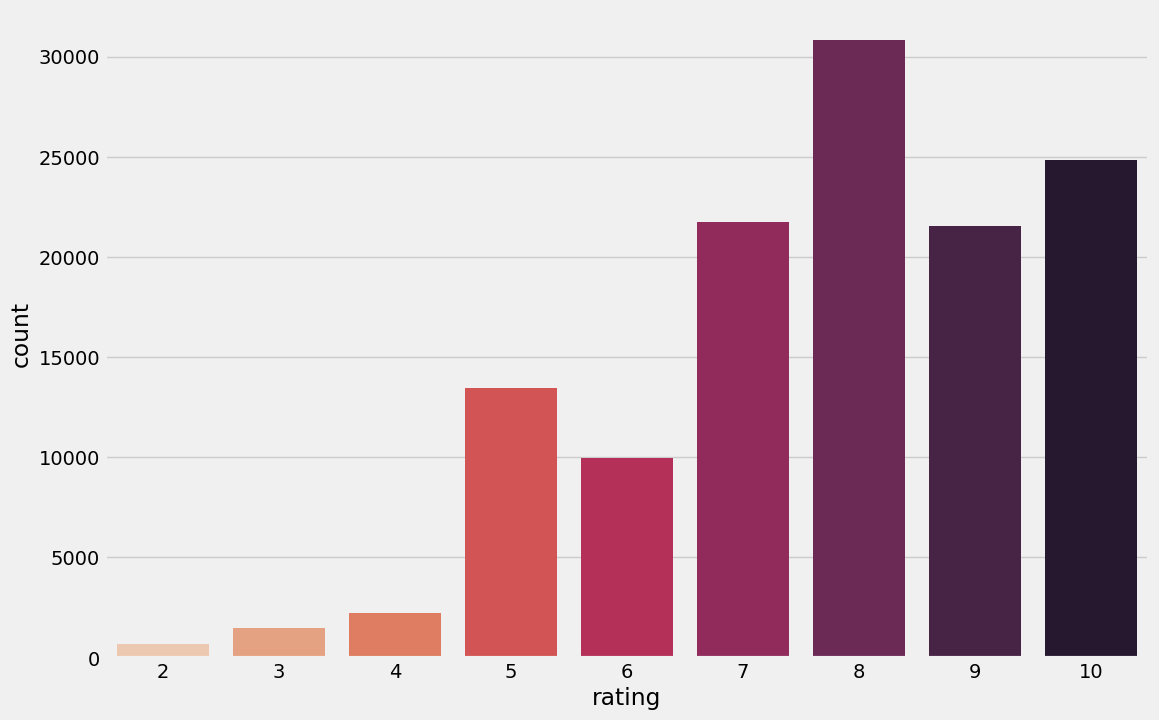

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

# Merge

이제 세 파일을 모두 합쳐서 컬럼간의 관계를 살펴보도록 하겠습니다.

In [50]:
merge1 = train_ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 18)


In [51]:
train_ratings.shape
# ratings 기록 갯수만큼 결과가 나온것을 확인 할 수 있습니다.

(306795, 3)

In [52]:
set(train_ratings['isbn']) - set(books['isbn']) 

set()

## 시각화

In [ ]:
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]

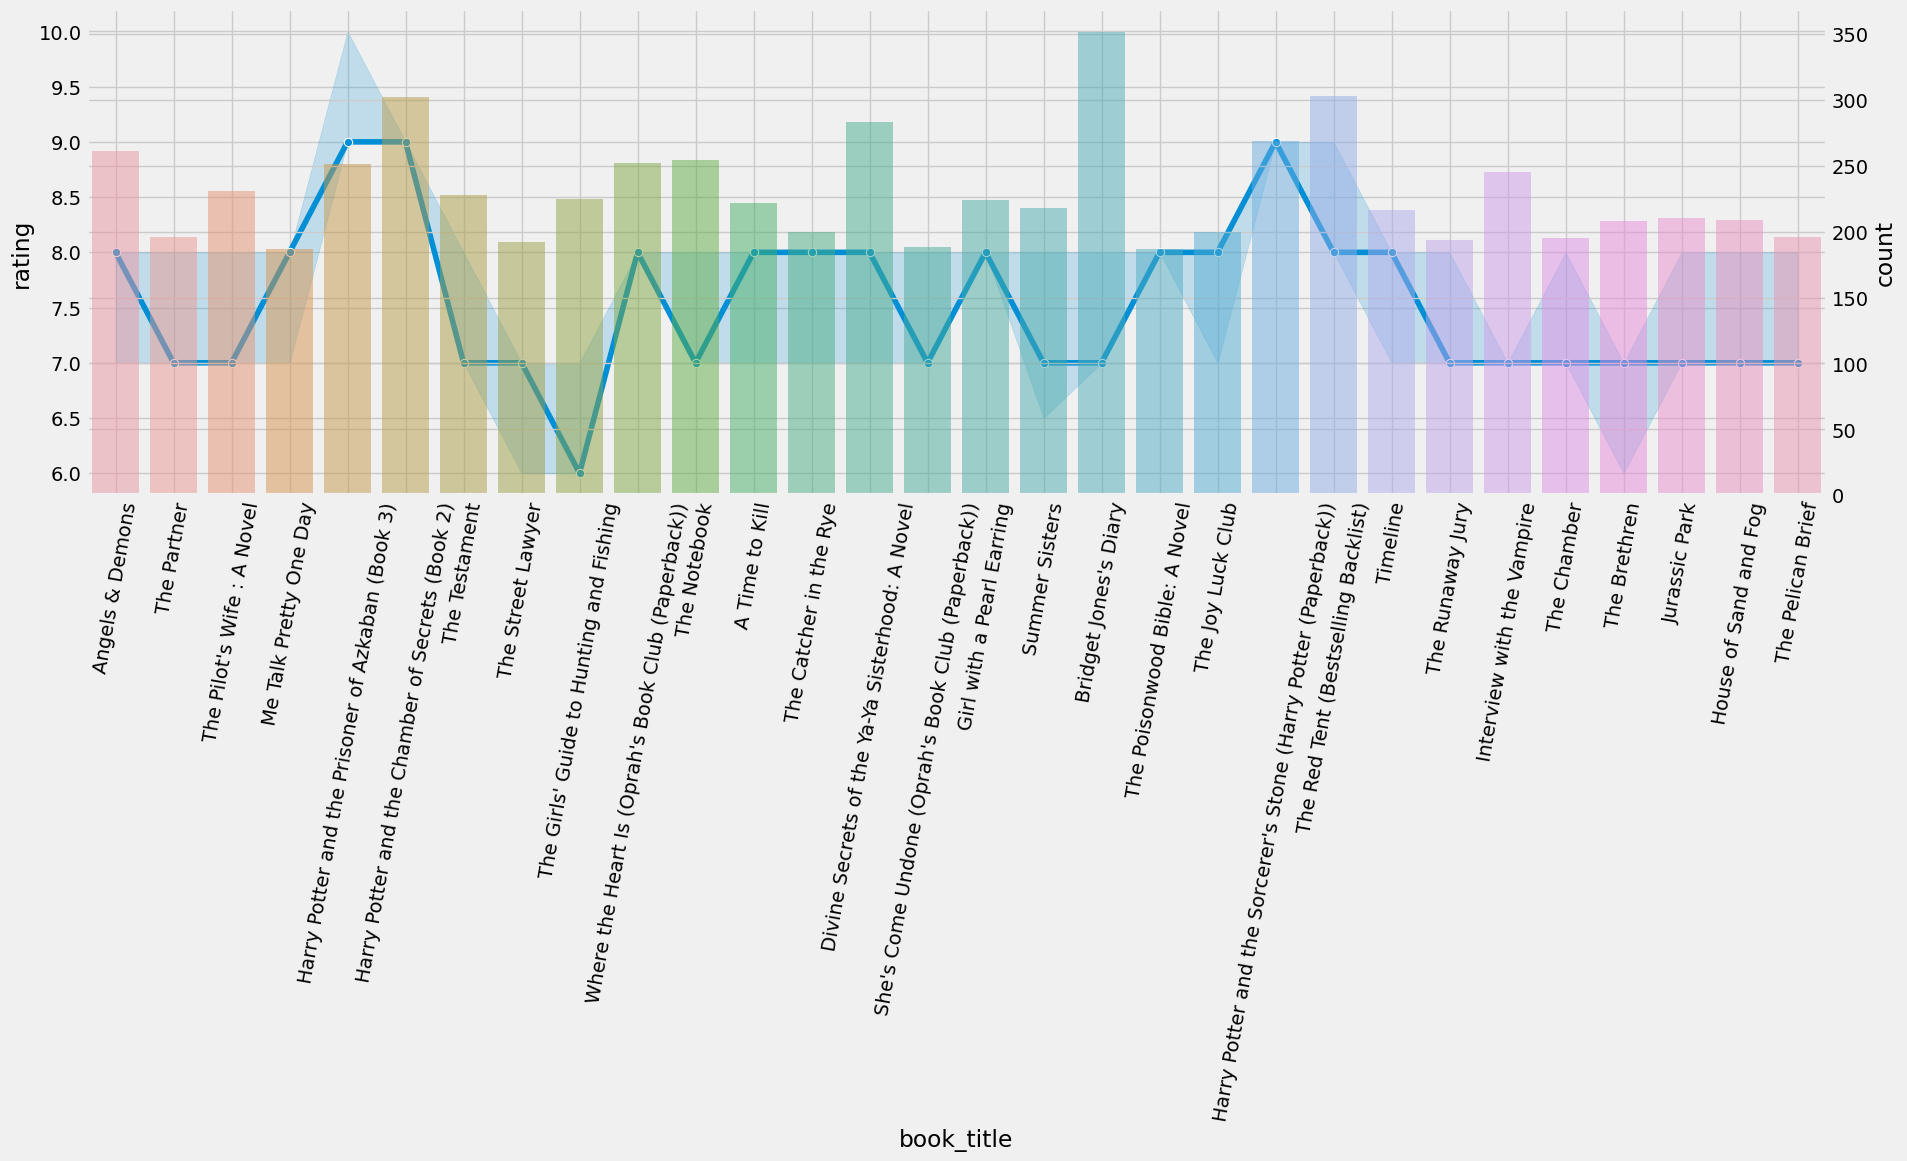

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

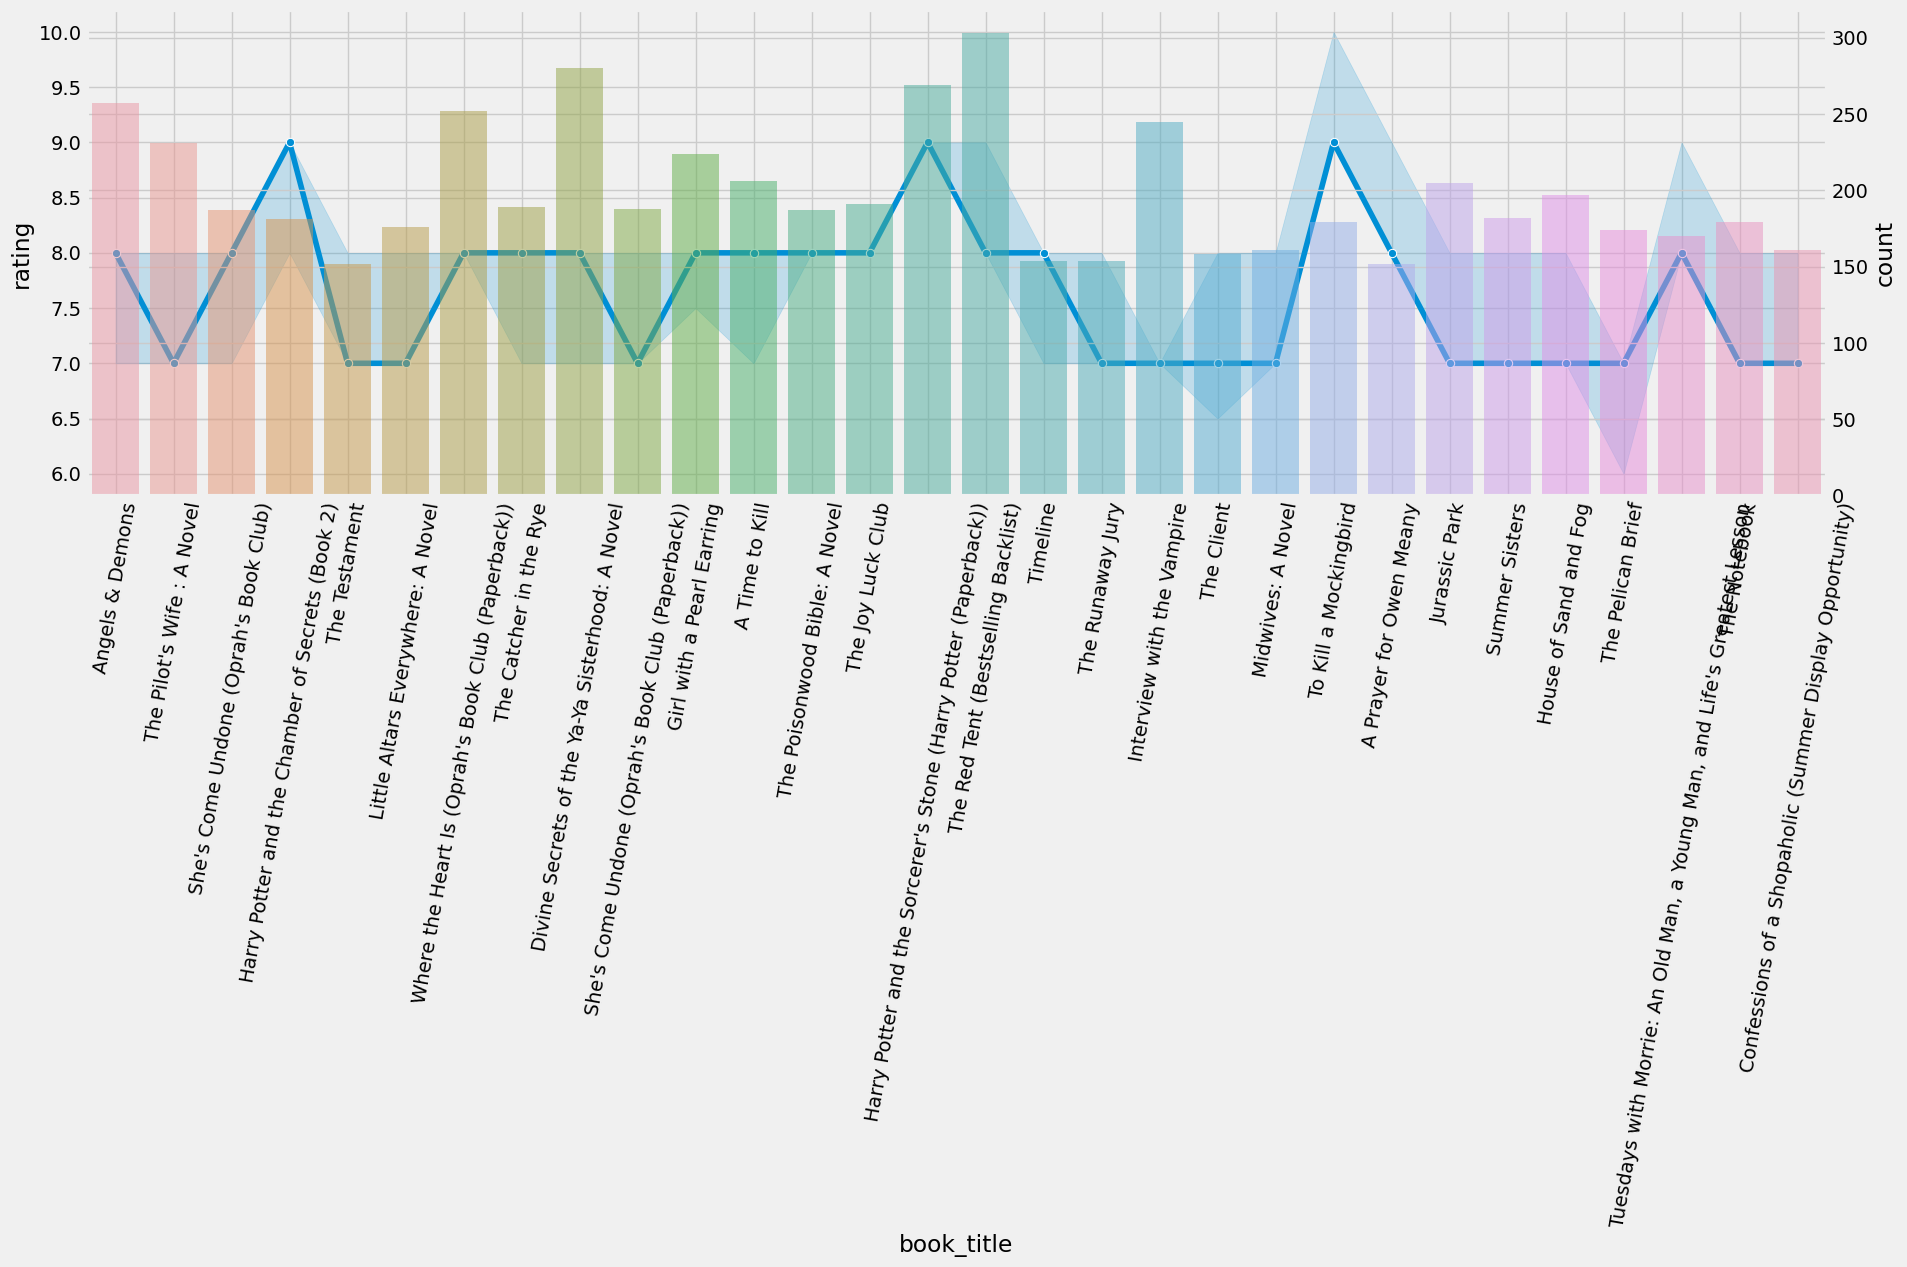

In [ ]:
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

book_title을 사용했을때와 isbn을 사용한 결과에 차이가 있는 것을 볼 수 있습니다.

이는 isbn이 책 고유번호로써 특정 국가에서 인기 차이가 반영되기 때문이라고 생각할 수 있습니다.

또한 가장 많이 읽힌 책이 오히려 median 및 평균이 낮은 것을 확인 할 수 있는데 이는 rating 1이 많아서 그런것일수도 있으므로 이를 제외해 보겠습니다.

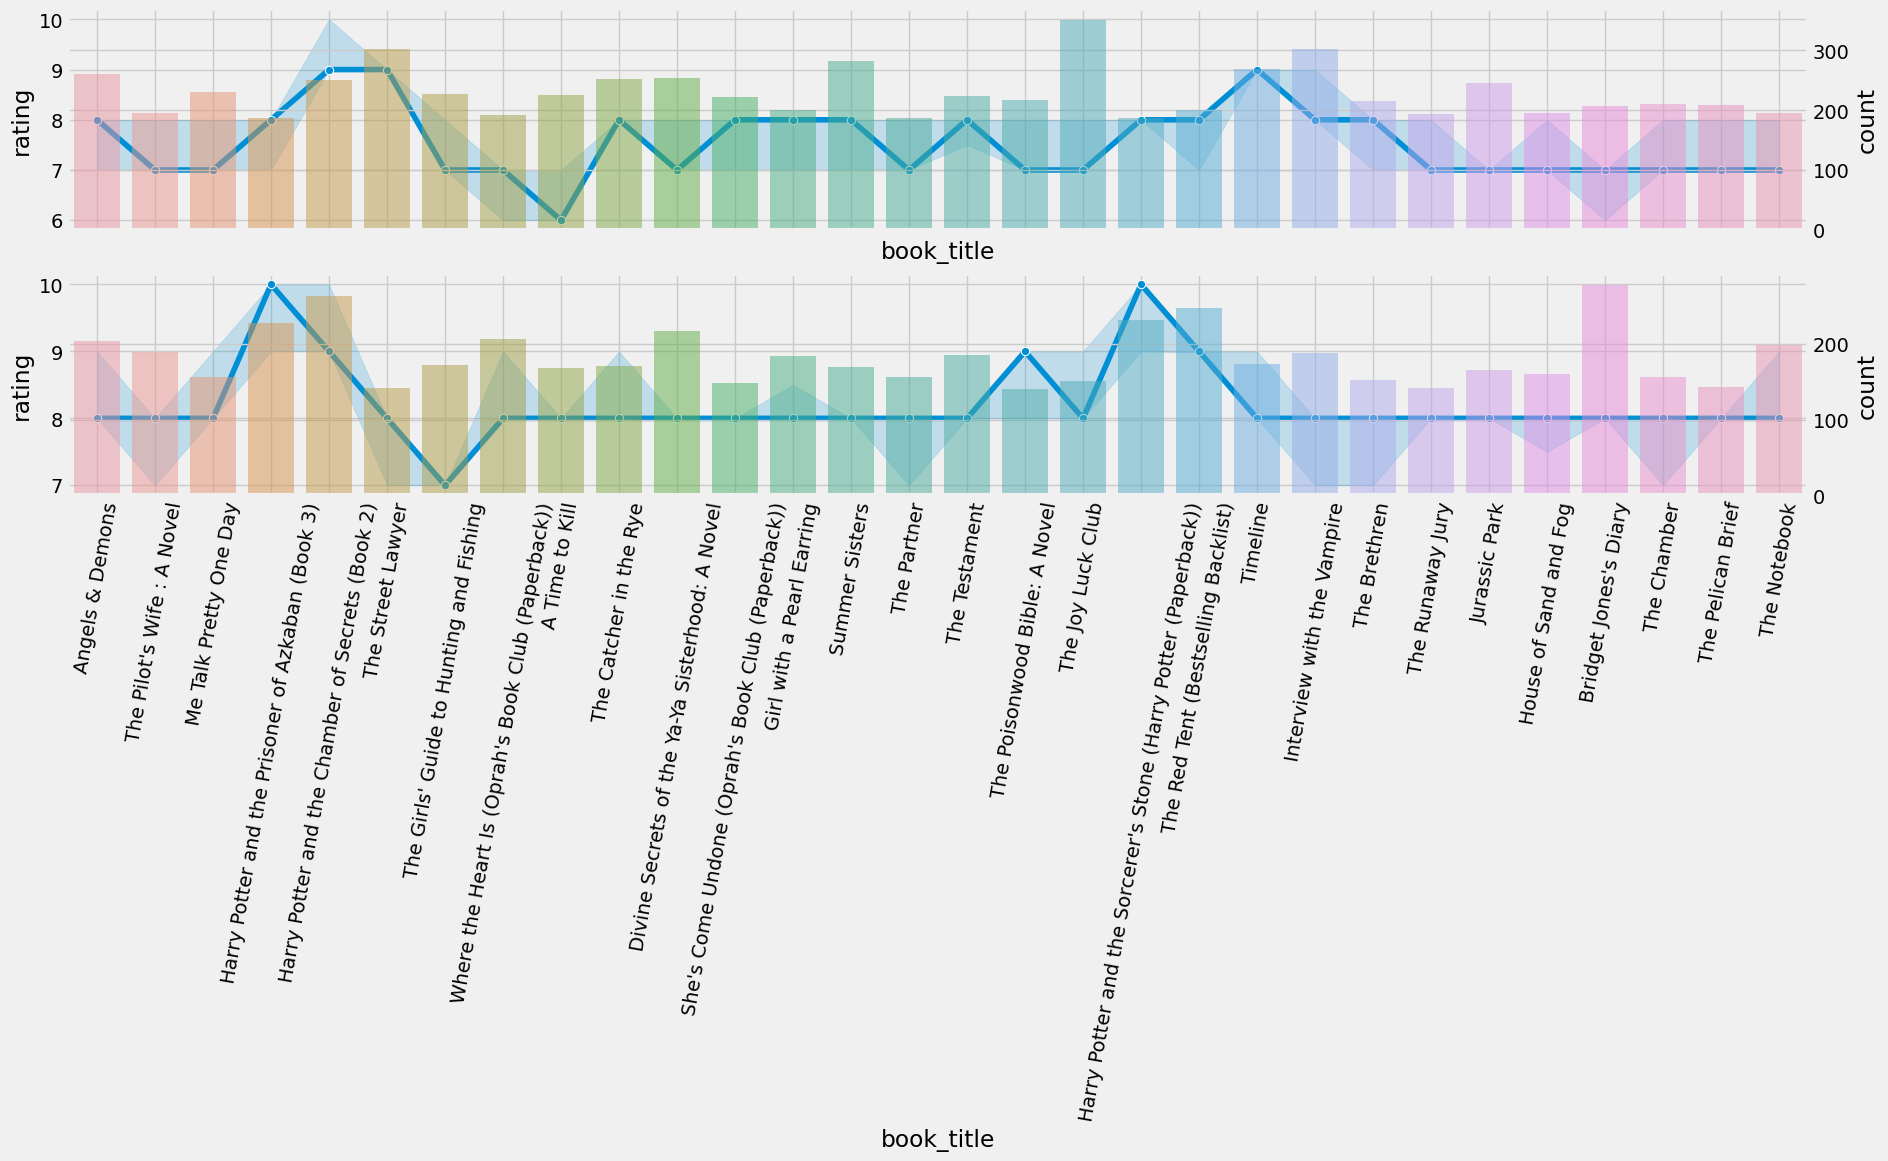

In [ ]:
# book title을 사용했을떄
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])


plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()

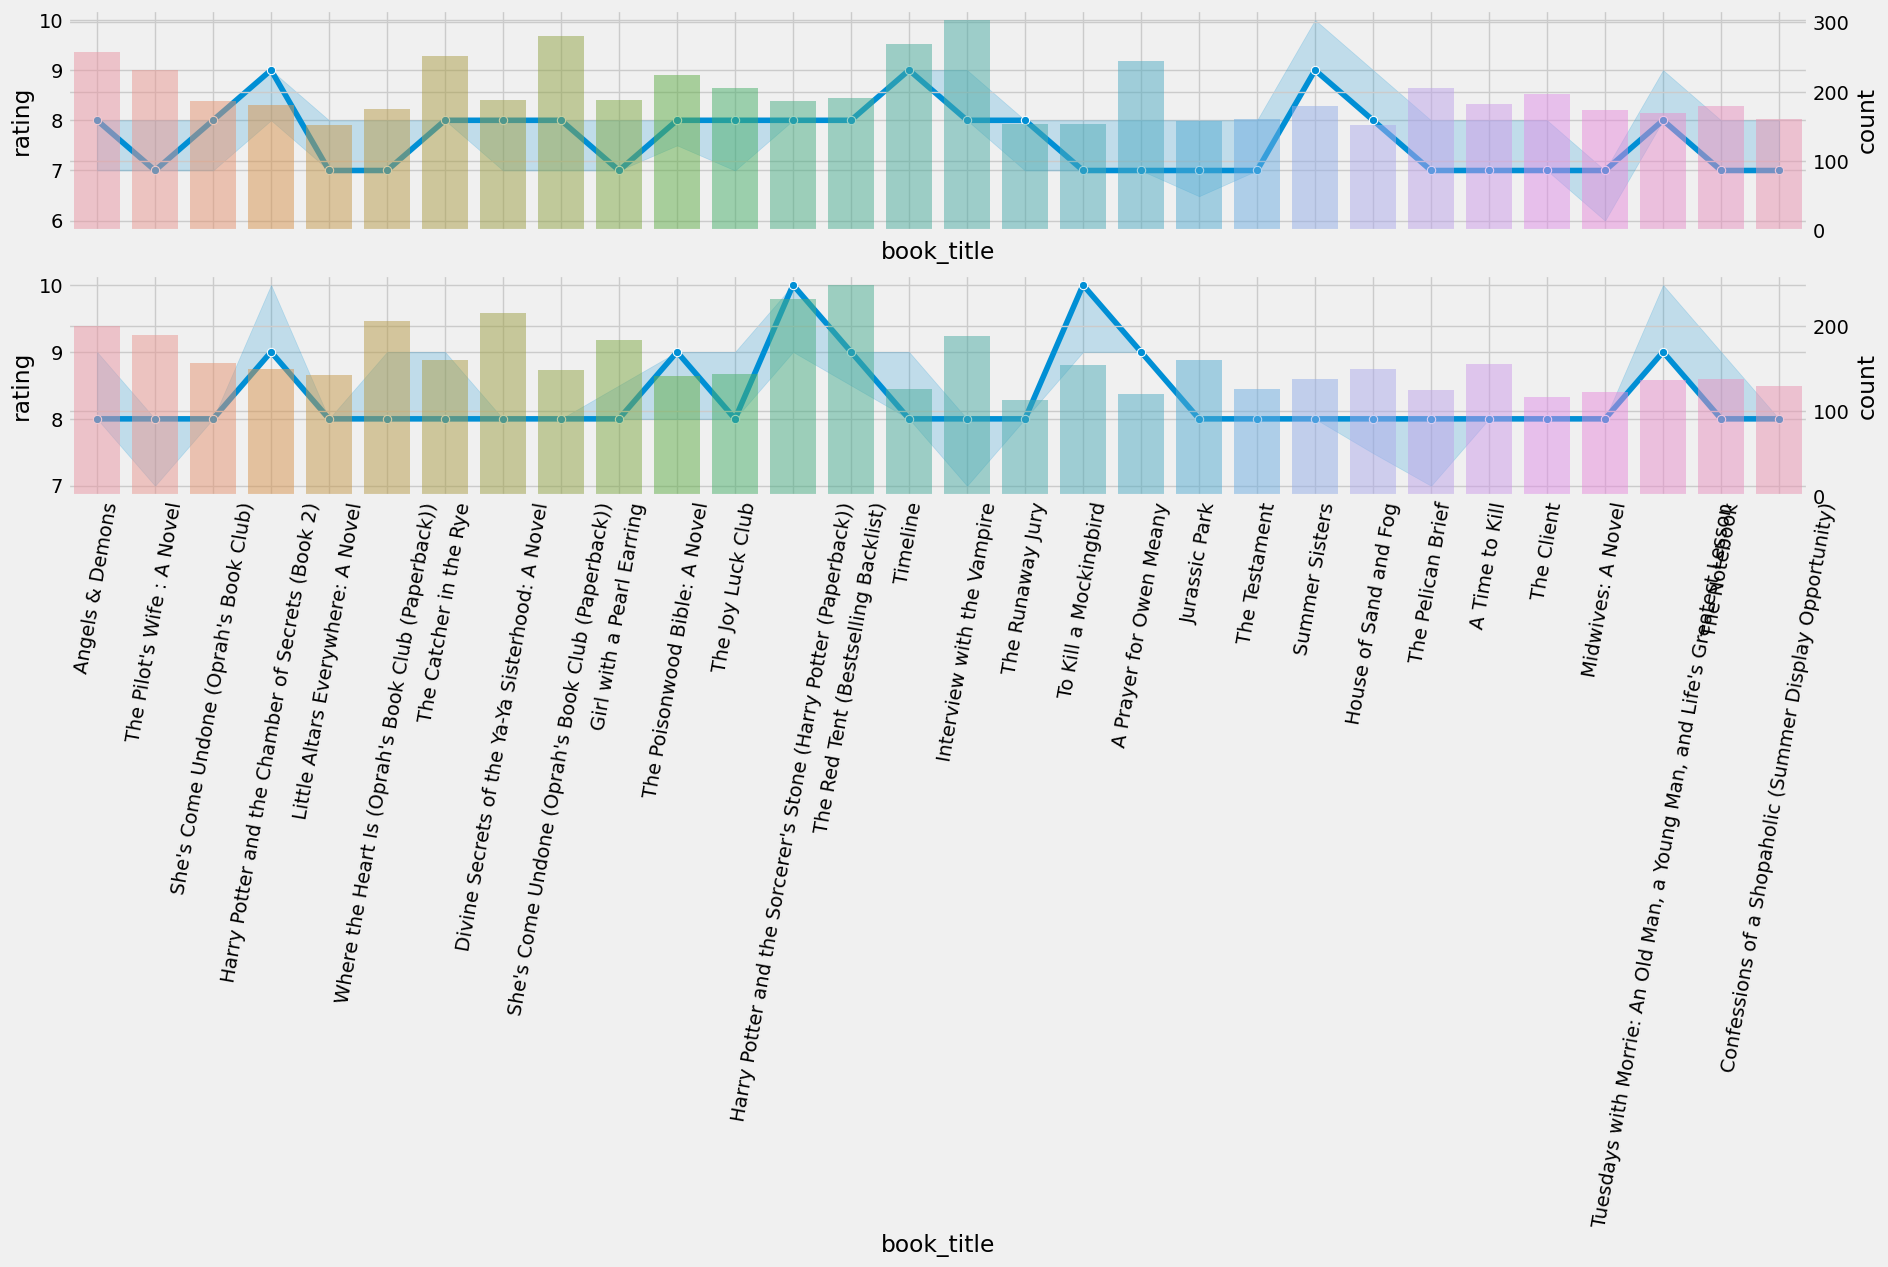

In [ ]:
# isbn을 사용했을 때
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()


많이 읽힌 책들은 중앙값 8점대를 형성하고 있음을 확인할 수 있습니다.

다음으로 book cate 별 rating 차이를 알아보겠습니다

앞서 만든 상위 카테고리를 활용하여 살펴보겠습니다.

In [ ]:
popular_cate_list = data['category_high'].value_counts().sort_values(ascending=False)[:10].index
popular_cate = data[data['category_high'].isin(popular_cate_list)]

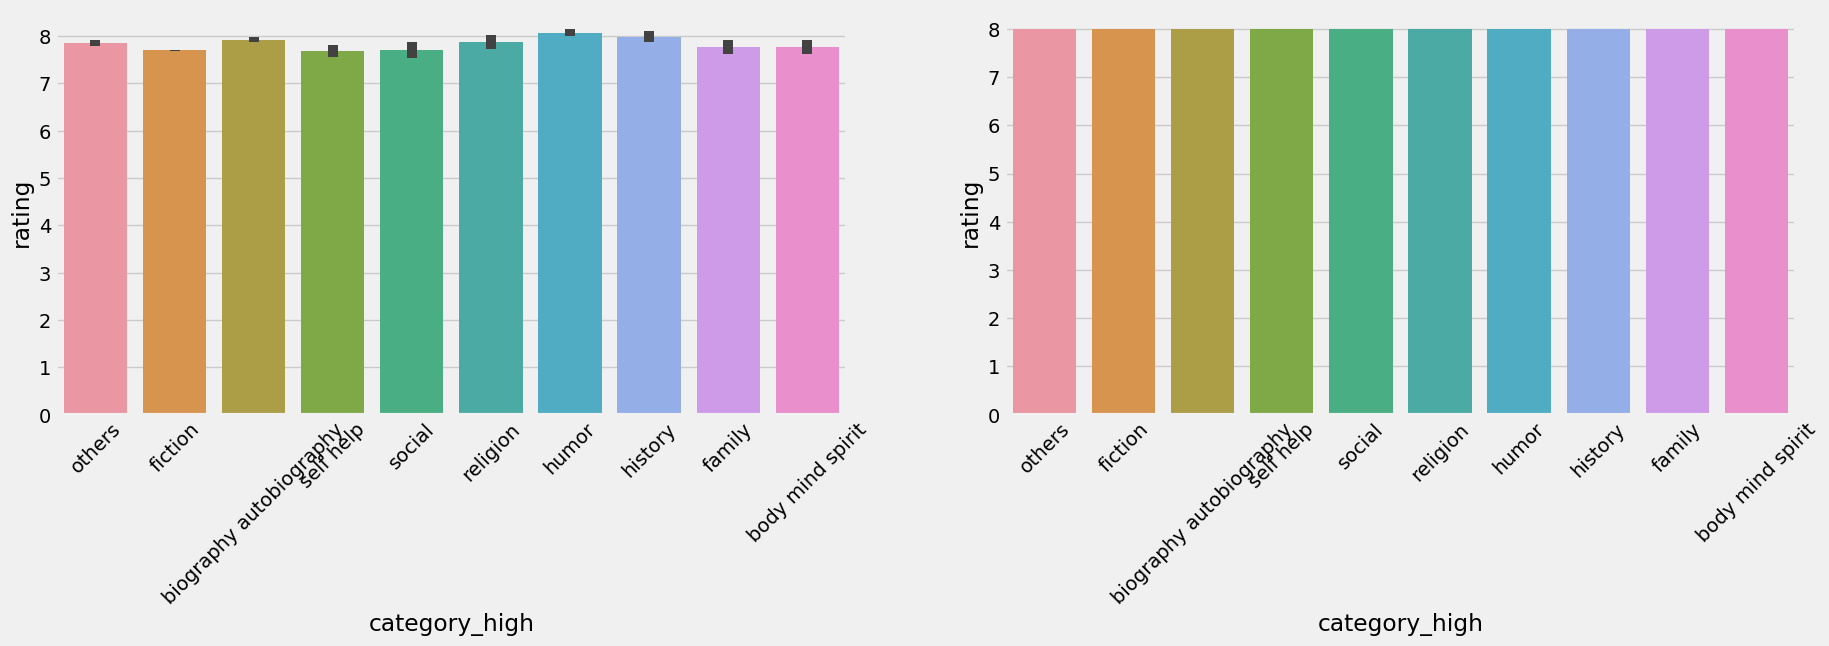

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot1 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category_high', y='rating', estimator=np.mean, ax=ax[0], )
plot2 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category_high', y='rating', estimator=np.median, ax=ax[1])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()

카테고리 간 점수차이는 크게 없습니다.

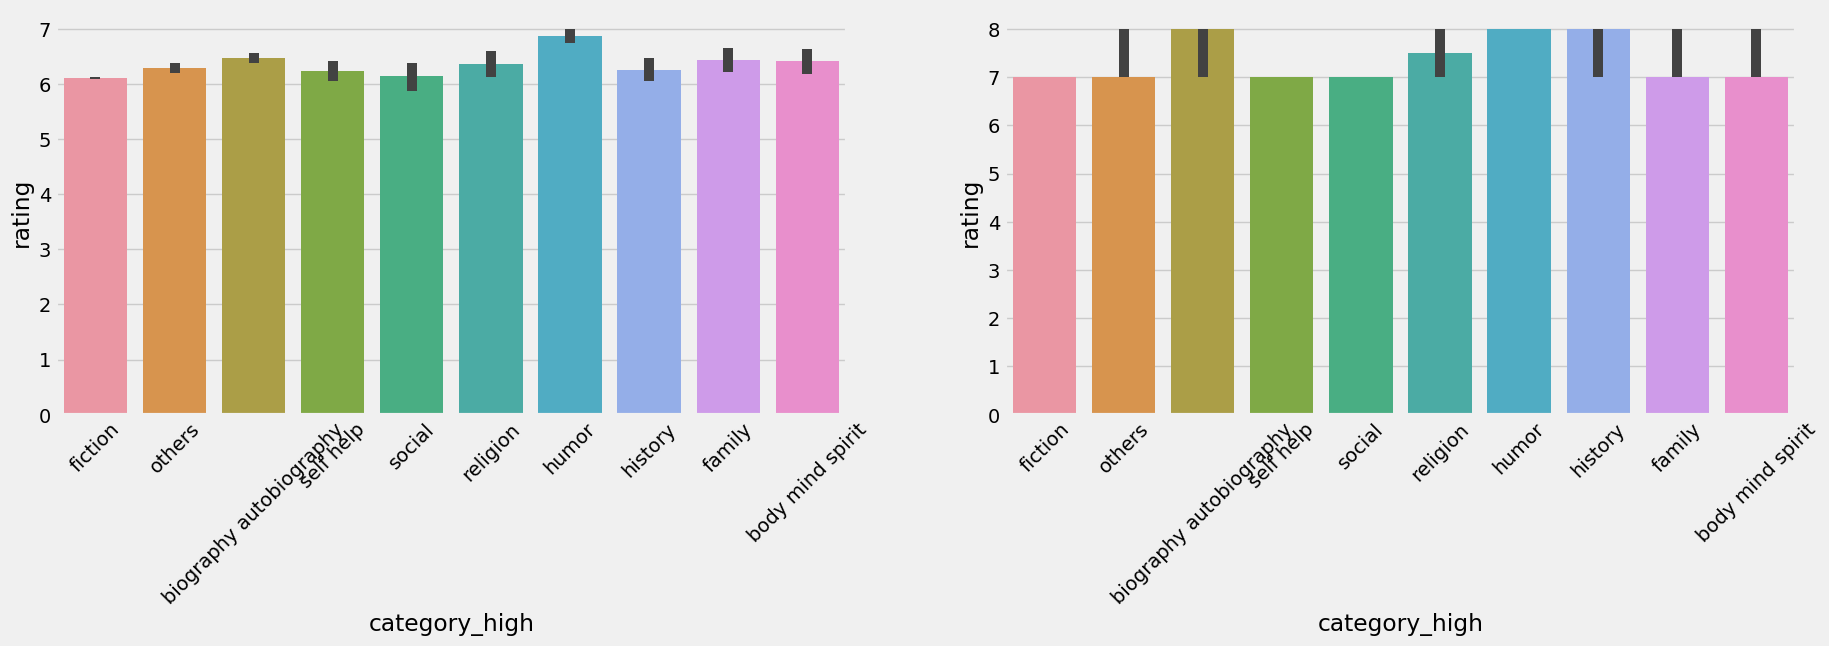

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot1 = sns.barplot(data=popular_cate, x='category_high', y='rating', estimator=np.mean, ax=ax[0], )
plot2 = sns.barplot(data=popular_cate, x='category_high', y='rating', estimator=np.median, ax=ax[1])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()

본 미션은 여기까지 입니다.

대회 데이터를 이해하고 이를 바탕으로 간단한 Feature engineering을 수행하는 시간을 가져보았습니다.

미션을 따라오시면서 궁금했던 점들을 직접 해보시면 데이터를 더 잘 이해할 수 있게 될 것입니다.

본 미션을 통해 분석 아이디어를 얻어서 대회에서 다양한 시도를 많이 해보시며 실력을 쌓으시길 바라겠습니다.




### 추가
- 인기가 중간인 책들의 평점은?
- 인기가 없는 책들의 평점은?

*isbn 기준으로, rating 1 제외해서 봄

In [ ]:
data['isbn'].value_counts()

0312195516    303
0060928336    280
059035342X    269
0671027360    257
0446672211    252
             ... 
0802132154      1
0345427173      1
034530280X      1
0590418211      1
0061044725      1
Name: isbn, Length: 20871, dtype: int64

인기가 중간인 책들 30개에 대해  살펴보기

In [ ]:
m_idx = data['isbn'].nunique() // 2

middle_book_list = data['isbn'].value_counts().sort_values(ascending=False)[m_idx-15 : m_idx+15].index # 중간 30개
middle_book = data[data['isbn'].isin(middle_book_list)]

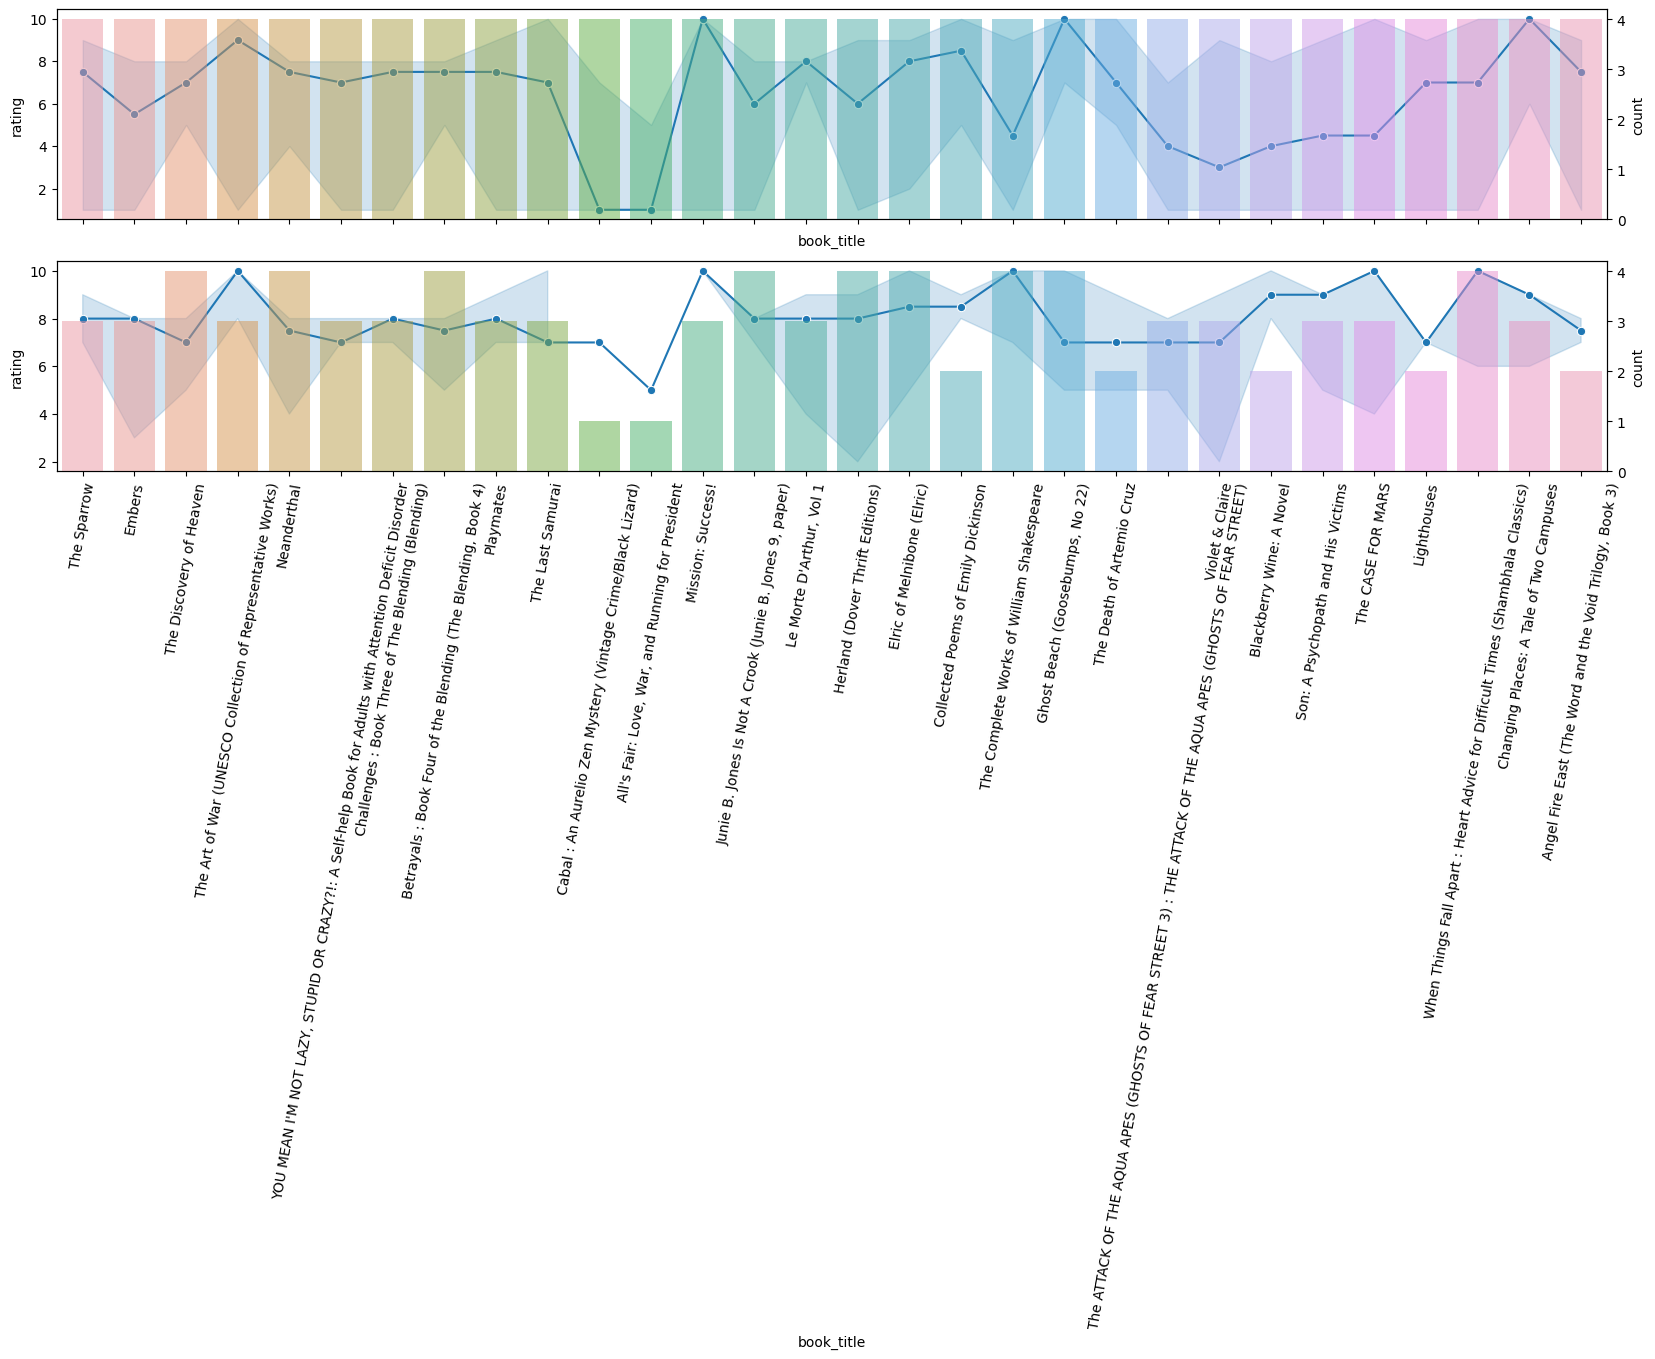

In [ ]:
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=middle_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=middle_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = middle_book[middle_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=middle_book[middle_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()

In [ ]:
middle_book.describe()

user_id      rating  year_of_publication         age
count     235.000000  235.000000           235.000000  176.000000
mean   139443.748936    6.080851          1992.902128   34.034091
std     83255.783143    3.121105            11.977320   10.300013
min       387.000000    1.000000          1932.000000   15.000000
25%     65558.000000    4.000000          1993.000000   27.000000
50%    143415.000000    7.000000          1995.000000   32.000000
75%    209338.000000    8.500000          1998.000000   39.000000
max    276847.000000   10.000000          2001.000000   67.000000

중간 위치에 있는 책들 count가 보통 3~4개이며 평점(의 medium)은 7점 정도이다.\
상위 30개 책들과 큰 차이는 안나지만, 상대적으로 평점이 조금 더 낮고 편차가 크다.\
대체로 count(읽힌 횟수, 즉 인기도)에 따라 rating도 낮아지는 경향이 보인다.

좀 더 넓게 보기 위해, 중간권 책들 중 랜덤으로 뽑아 살펴 보기 \
상위 5000개, 하위 5000개 책 제외한 나머지 책들 중 50개 랜덤 추출

In [ ]:
data['isbn'].nunique()

20871

In [ ]:
data['isbn'].value_counts().sort_values(ascending=False).index # 인기순 isbn

Index(['0312195516', '0060928336', '059035342X', '0671027360', '0446672211',
       '0345337662', '0316601950', '0452282152', '0440211727', '0345370775',
       ...
       '0345324455', '1551662663', '0786813881', '0060925515', '0425166120',
       '0451188241', '0590460544', '0312969759', '0886773733', '0061044725'],
      dtype='object', length=20871)

In [ ]:
import random
random.seed(100)

rand_idx = sorted([random.randint(5000, data['isbn'].nunique() - 5000) for _ in range(50)])
print(rand_idx)

[5092, 5428, 5784, 6313, 6801, 6987, 7033, 7307, 7386, 7418, 7628, 7663, 7736, 7863, 7923, 7959, 8089, 8156, 8340, 8350, 8454, 8763, 8886, 9315, 9518, 10069, 10494, 10685, 10730, 11063, 11145, 11439, 11480, 11603, 11712, 12102, 12453, 12470, 12528, 12554, 13304, 13731, 14099, 14275, 14875, 15261, 15460, 15608, 15625, 15794]


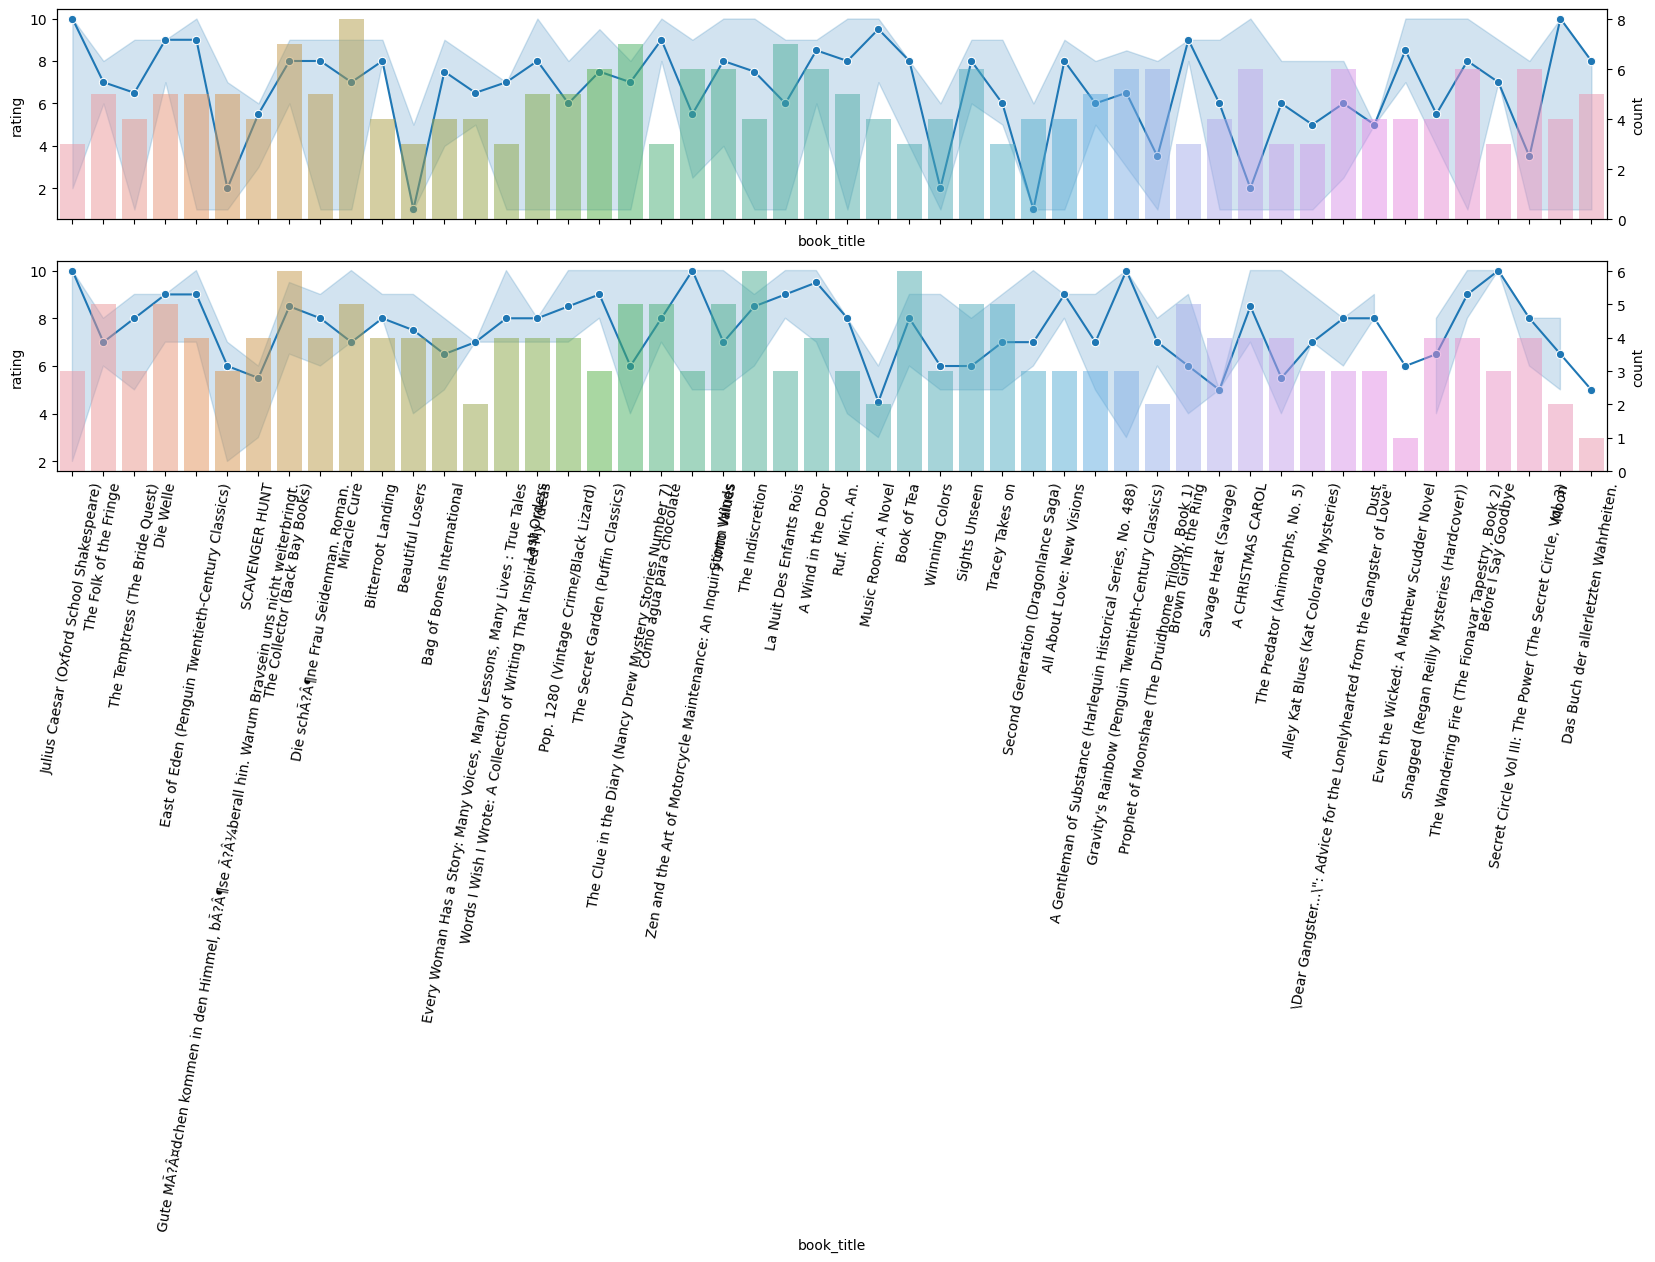

In [ ]:
middle_book_list2 = data['isbn'].value_counts().sort_values(ascending=False)[rand_idx].index
middle_book2 = data[data['isbn'].isin(middle_book_list2)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=middle_book2,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=middle_book2, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = middle_book2[middle_book2['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=middle_book2[middle_book2['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()


In [ ]:
middle_book2.describe()

user_id      rating  year_of_publication         age
count     235.000000  235.000000           235.000000  176.000000
mean   139443.748936    6.080851          1992.902128   34.034091
std     83255.783143    3.121105            11.977320   10.300013
min       387.000000    1.000000          1932.000000   15.000000
25%     65558.000000    4.000000          1993.000000   27.000000
50%    143415.000000    7.000000          1995.000000   32.000000
75%    209338.000000    8.500000          1998.000000   39.000000
max    276847.000000   10.000000          2001.000000   67.000000

중간 30개를 뽑았을 때와 비슷하다.\
medium 값이 7점 정도이며 편차가 크다.\
마찬가지로 count가 낮으면 rating도 낮은 경향이 있다.

하위 30개의 책 살펴보기

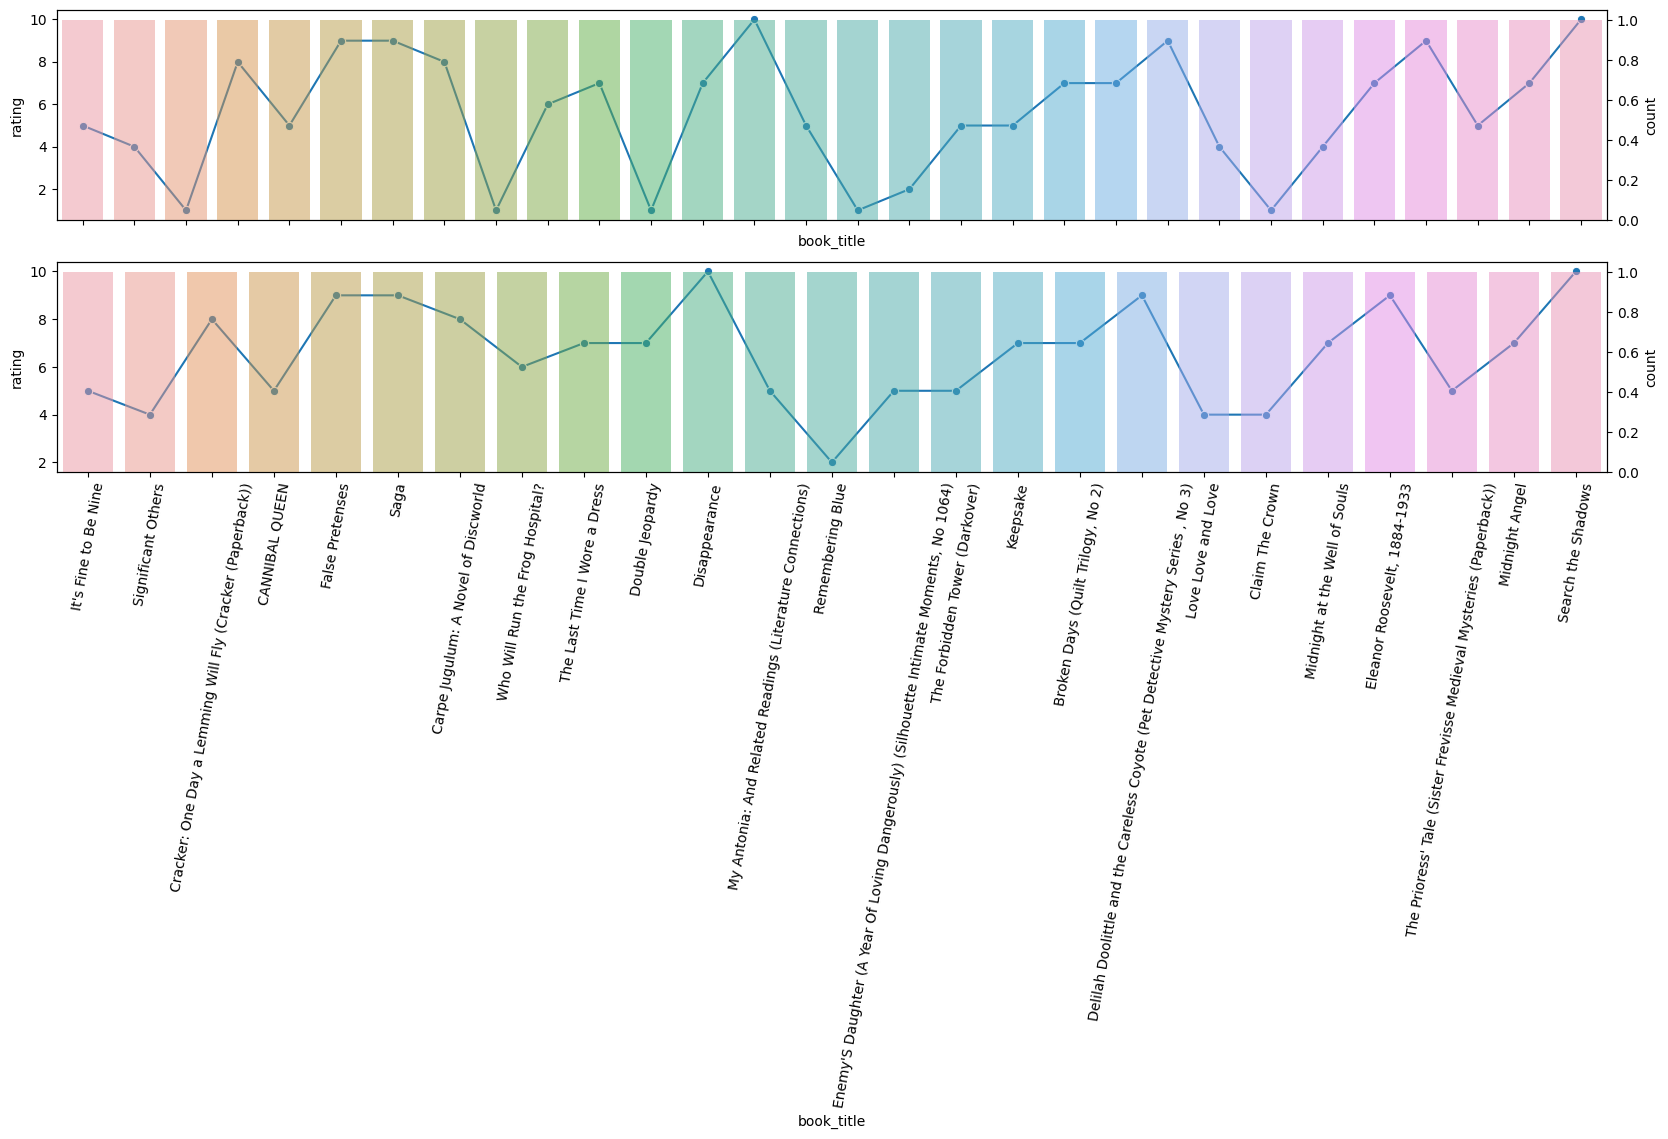

In [ ]:
unpopular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[-30:].index
unpopular_book = data[data['isbn'].isin(unpopular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=unpopular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=unpopular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

plot2 = sns.lineplot(data = unpopular_book[unpopular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=unpopular_book[unpopular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()

In [ ]:
unpopular_book.describe()

user_id     rating  year_of_publication        age
count      30.000000  30.000000            30.000000  19.000000
mean   237734.266667   5.633333          1996.466667  40.842105
std     22409.749515   2.858542             3.739199  13.659605
min    189835.000000   1.000000          1987.000000  17.000000
25%    243110.250000   4.000000          1994.250000  34.000000
50%    246069.500000   5.500000          1997.500000  42.000000
75%    247965.250000   7.750000          1999.000000  46.500000
max    278582.000000  10.000000          2001.000000  80.000000

하위 30개는 count가 모두 1이다.\
대체로 5점 정도에 많이 분포하는 것으로 보인다.

In [ ]:
data.corr()

<ipython-input-135-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


user_id    rating  year_of_publication       age
user_id              1.000000 -0.016597             0.001103 -0.012812
rating              -0.016597  1.000000            -0.045742 -0.012324
year_of_publication  0.001103 -0.045742             1.000000  0.056209
age                 -0.012812 -0.012324             0.056209  1.000000